final

# Phtomometric Redshift estimation

We will try to estimate the redshift from DES data using the match from the VVDS.

We use Machine Learning methods and Deep learning methods

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/rafaelmgr12/PHOTOzxcorr/main/functions/ml_functions.py -O ml_functions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/PHOTOzxcorr/functions/") # user here the path where we download the folder DESzxcoorr
    
    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import os,sys
import matplotlib
from astropy.table import Table
import seaborn as sns
import time

# Regression Libraries
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor,StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb
 


# Other Libraries
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics


# Neural Network Libs
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix
import keras as ks
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers
from tensorflow.keras import regularizers


%matplotlib inline

In [3]:
def clean_tab(tab,col,val):
    tab.drop(tab[tab[col]==val].index,inplace = True)
def tts_split(X,y,size):
    rs = ShuffleSplit(n_splits=5, test_size=size)
    rs.get_n_splits(X)
    for train_index, test_index in rs.split(X, y): 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test,y_train, y_test

n_folds = 5

def rmsle_cv(model,X_train,y_train):
    kf = KFold(3, shuffle=True, random_state=None).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def rmse_ann(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann2(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann3(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann4(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def get_features_targets(data):
    features = np.zeros(shape=(len(data), 4))
    
    features[:, 0] = data['MAG_AUTO_G'].values - data['MAG_AUTO_R'].values
    features[:, 1] = data['MAG_AUTO_R'].values - data['MAG_AUTO_I'].values
    features[:, 2] = data['MAG_AUTO_I'].values - data['MAG_AUTO_Z'].values
    features[:, 3] = data['MAG_AUTO_Z'].values - data['MAG_AUTO_Y'].values
    #features[:, 4] = data['WAVG_MAG_PSF_G'] - data['WAVG_MAG_PSF_R']
    #features[:, 5] = data['WAVG_MAG_PSF_R'] - data['WAVG_MAG_PSF_I']
    #features[:, 6] = data['WAVG_MAG_PSF_I'] - data['WAVG_MAG_PSF_Z']
    #features[:, 7] = data['WAVG_MAG_PSF_Z'] - data['WAVG_MAG_PSF_Y']

    
    
    targets = data['z']
    return features, targets

def get_features_targets2(data):
    features = np.zeros(shape=(len(data), 4))
    
    features[:, 0] = data['MAG_AUTO_G_DERED'].values - data['MAG_AUTO_R_DERED'].values
    features[:, 1] = data['MAG_AUTO_R_DERED'].values - data['MAG_AUTO_I_DERED'].values
    features[:, 2] = data['MAG_AUTO_I_DERED'].values - data['MAG_AUTO_Z_DERED'].values
    features[:, 3] = data['MAG_AUTO_Z_DERED'].values - data['MAG_AUTO_Y_DERED'].values
    #features[:, 4] = data['WAVG_MAG_PSF_G_DERED'] - data['WAVG_MAG_PSF_R_DERED']
    #features[:, 5] = data['WAVG_MAG_PSF_R_DERED'] - data['WAVG_MAG_PSF_I_DERED']
    #features[:, 6] = data['WAVG_MAG_PSF_I_DERED'] - data['WAVG_MAG_PSF_Z_DERED']
    #features[:, 7] = data['WAVG_MAG_PSF_Z_DERED'] - data['WAVG_MAG_PSF_Y_DERED']

       
    targets = data['z'].values
    return features, targets


def smote(X,y,n,k):
    if n == 0:
        return X,y
    knn = KNeighborsRegressor(k,"distance").fit(X,y)
    # choose random neighbors of random points
    ix = np.random.choice(len(X),n)
    nn = knn.kneighbors(X[ix],return_distanec = False)
    newY = knn.predict(X[ix])
    nni = np.random.choice(k,n)
    ix2 = np.array([n[i] for n,i in zip(nn,nni)])
    
    # synthetically generate mid-point between each point and a neighbor
    dif = X[ix] -X[ix2]
    gap = np.random.rand(n,1)
    newX = X[ix] + dif*gap
    return np.r_[X,newX],np.r_[y,newY]

In [4]:
if IN_COLAB:
    path1 = "/content/drive/Shareddrives/Optical Data/DES Data/match-des-ps2"
    path2 = "/content/drive/Shareddrives/Optical Data/DES Data/results/PSPixelFit_PS1_VIPERS_VVDS"
    path3 = "/content/drive/Shareddrives/Optical Data/DES Data/64"
else:
    path1 = home+"/PHOTOzxcorr/data/des_vvds"
    path2 = home+"/PHOTOzxcorr/data/vipers.fits"
    path3 = home+"/PHOTOzxcorr/data/OzDES_GRC_2018_12_07.fits"

In [5]:
filename1 = os.listdir(path1)
#filename2 = os.listdir(path2)
#filename3 = os.listdir(path3)

In [6]:
vipers = Table.read(path2).to_pandas()
tab = Table.read(path3).to_pandas()

In [7]:
l1 = []
for i in range(len(filename1)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path1,filename1[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
des = pd.concat(l1, axis=0, ignore_index=True)
del df,l1


In [8]:
tab.head()

ID         RA        DEC       z  z_Err  \
0  b'APMUKS(BJ) B033420.07-271928.1'  54.108429 -27.159910  0.2440 -9.999   
1  b'APMUKS(BJ) B033411.69-271617.8'  54.073959 -27.106859  0.1015 -9.999   
2  b'GALEX J033649.0-271938        '  54.204361 -27.327370  0.1458 -9.999   
3  b'[ECD2009] J053.96796-27.00658 '  53.967960 -27.006580  0.9389 -9.999   
4  b'GALEXASC J033629.56-272329.8  '  54.123421 -27.391560  0.3502 -9.999   

      flag  source comments  totobs  totexp  
0  b'    '  b'NED'     b'-'      -9      -9  
1  b'    '  b'NED'     b'-'      -9      -9  
2  b'    '  b'NED'     b'-'      -9      -9  
3  b':   '  b'NED'     b'-'      -9      -9  
4  b'    '  b'NED'     b'-'      -9      -9

In [9]:
vipers.head()

ID       RA_1     DEC_1       z  z_Err     flag  \
0  b'VIPERS 110183204'  30.938091 -4.777137  0.8625 -9.999  b' 2.2'   
1  b'VIPERS 107103627'  36.644029 -5.977520  0.8799 -9.999  b' 2.5'   
2  b'VIPERS 107103628'  36.672479 -5.977282  0.5614 -9.999  b' 4.4'   
3  b'VIPERS 107103698'  36.678549 -5.976197  0.8175 -9.999  b' 2.5'   
4  b'VIPERS 107103810'  36.810072 -5.976481  0.9880 -9.999  b' 3.5'   

      source comments  totobs  totexp  ...  SPREADERR_MODEL_R  \
0  b'VIPERS'     b'-'      -9      -9  ...           0.005274   
1  b'VIPERS'     b'-'      -9      -9  ...           0.002011   
2  b'VIPERS'     b'-'      -9      -9  ...           0.000984   
3  b'VIPERS'     b'-'      -9      -9  ...           0.002790   
4  b'VIPERS'     b'-'      -9      -9  ...           0.004319   

  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
0          0.003328           0.004998           0.017579   
1          0.001790           0.002247           0.011369   
2          0.000720           0.000835           0.003422   
3          0.001830           0.002291           0.009595   
4          0.002232           0.001744           0.008616   

   WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
0              -99.000000              -99.000000                0.003946   
1                0.003144                0.003403                0.002033   
2                0.002639                0.001304                0.000754   
3                0.003182                0.004029                0.002431   
4              -99.000000                0.006201                0.002499   

   WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y    random  
0              -99.000000              -99.000000  0.846429  
1                0.002936              -99.000000  0.080008  
2                0.000884                0.003498  0.522909  
3                0.002787              -99.000000  0.891630  
4                0.002281              -99.000000  0.693547  

[5 rows x 224 columns]

In [10]:
des.head()

COADD_OBJECT_ID         TILENAME  HPIX_32  HPIX_64  HPIX_1024  HPIX_4096  \
0        114214716  b'DES0223-0416'     4423    17692    4529384   72470148   
1        114214723  b'DES0223-0416'     4423    17692    4529343   72469491   
2        114214739  b'DES0223-0416'     4423    17692    4529341   72469470   
3        114214908  b'DES0223-0416'     4423    17692    4529384   72470149   
4        114214918  b'DES0223-0416'     4423    17692    4529378   72470062   

   HPIX_16384         RA       DEC  ALPHAWIN_J2000  ...  SPREADERR_MODEL_G  \
0  1159522371  36.321737 -3.932205       36.321737  ...           0.003469   
1  1159511864  36.204853 -3.933261       36.204853  ...           0.005400   
2  1159511534  36.241067 -3.932187       36.241067  ...           0.006617   
3  1159522384  36.331422 -3.928531       36.331422  ...           0.024521   
4  1159520995  36.333934 -3.940790       36.333934  ...           0.005289   

   SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
0           0.001998           0.001891           0.003411           0.008147   
1           0.004042           0.003825           0.006764           0.013959   
2           0.004248           0.005029           0.009526           0.020347   
3           0.004013           0.009131           0.009831           0.031480   
4           0.003785           0.007565           0.005660           0.011424   

   WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
0                0.003786                0.002102                0.002157   
1              -99.000000              -99.000000                0.003972   
2              -99.000000                0.005225              -99.000000   
3              -99.000000              -99.000000              -99.000000   
4              -99.000000                0.003899              -99.000000   

   WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
0                0.003472                   -99.0  
1              -99.000000                   -99.0  
2              -99.000000                   -99.0  
3              -99.000000                   -99.0  
4                0.005769                   -99.0  

[5 rows x 213 columns]

In [11]:
originalTam = len(vipers)

**Counting the Galaxies of our Catalog**


In [12]:
pix = des['HPIX_1024'].unique()
pix_match = vipers["HPIX_1024"].unique()

num_des = []
avg_des = []
num_vipers = []
avg_vipers = []
for i in range(len(pix)):
    avg_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].count())
for i in range(len(pix_match)):  
    avg_vipers.append(vipers[vipers['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].mean())
    num_vipers.append(vipers[vipers['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].count())

In [13]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)

avg_vipers = np.asarray(avg_vipers)
num_vipers = np.asarray(num_vipers)

In [14]:
galaxies_des = pd.DataFrame(pix,columns=['HPIX_1024'])
galaxies_vipers = pd.DataFrame(pix_match,columns=['HPIX_1024'])
galaxies_des['AVG_des'] = avg_des
galaxies_des['COUNT_des'] = num_des
galaxies_vipers['AVG_vipers'] = avg_vipers
galaxies_vipers['COUNT_vipers'] = num_vipers

In [15]:
print("Galaxies in VIPERSxDES match: ",galaxies_vipers['COUNT_vipers'].sum(),"\n Galaxies in Des",galaxies_des['COUNT_des'].sum())

Galaxies in VIPERSxDES match:  47658 
 Galaxies in Des 163350


In [16]:
pix_des = galaxies_des.HPIX_1024.values
pix_vipers = galaxies_vipers.HPIX_1024.values

In [17]:
num_des = []
avg_des = []
for i in range(len(pix_vipers)):
    avg_des.append(des[des['HPIX_1024']==pix_vipers[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix_vipers[i]]['MAG_AUTO_I'].count())

In [18]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)


In [19]:
galaxies_desd = pd.DataFrame(pix_vipers,columns=['HPIX_1024'])
galaxies_desd['AVG_des'] = avg_des
galaxies_desd['COUNT_des'] = num_des

In [20]:
print("Galaxies contained in the DES catalogue",galaxies_desd['COUNT_des'].sum())

Galaxies contained in the DES catalogue 83537


In [21]:
print("Galaxies that are not contained in the match",galaxies_desd['COUNT_des'].sum()-galaxies_vipers["COUNT_vipers"].sum())

Galaxies that are not contained in the match 35879


In [22]:
print("We have {:f}% of the galaxies with the match".format(100*((galaxies_desd['COUNT_des'].sum()-galaxies_vipers["COUNT_vipers"].sum())/galaxies_desd['COUNT_des'].sum())))

We have 42.949831% of the galaxies with the match


In [23]:
vipers_original = tab[(tab['source']==b'VIPERS')].copy()

In [24]:
vipers_original.head()

ID         RA       DEC       z  z_Err     flag  \
83941  b'VIPERS 101121877'  30.815165 -5.974833  0.2096 -9.999  b'23.4'   
83942  b'VIPERS 101122068'  30.443040 -5.977533  1.0308 -9.999  b' 2.4'   
83943  b'VIPERS 101122081'  30.949897 -5.975704  0.5115 -9.999  b' 4.4'   
83944  b'VIPERS 101122084'  30.401492 -5.977889  0.4746 -9.999  b' 3.5'   
83945  b'VIPERS 101122144'  30.399067 -5.977321  0.8135 -9.999  b' 4.5'   

          source comments  totobs  totexp  
83941  b'VIPERS'     b'-'      -9      -9  
83942  b'VIPERS'     b'-'      -9      -9  
83943  b'VIPERS'     b'-'      -9      -9  
83944  b'VIPERS'     b'-'      -9      -9  
83945  b'VIPERS'     b'-'      -9      -9

In [25]:
print("Galaxies contained in the VIPERS catalogue",len(vipers_original))

Galaxies contained in the VIPERS catalogue 52983


In [26]:
print("Galaxies that are not contained in the match",len(vipers_original)-galaxies_vipers["COUNT_vipers"].sum())

Galaxies that are not contained in the match 5325


**Characterization of the Galaxies**

In [27]:
vipers_matchID = vipers["ID"]
vipers_originalID = vipers_original["ID"]

In [28]:
vipers_matchID = np.asarray(vipers_matchID)
vipers_originalID = np.asarray(vipers_originalID)

In [29]:
vipers_matchID,vipers_originalID

(array([b'VIPERS 110183204', b'VIPERS 107103627', b'VIPERS 107103628', ...,
        b'VIPERS 116027557', b'VIPERS 116031855', b'VIPERS 116031866'],
       dtype=object),
 array([b'VIPERS 101121877', b'VIPERS 101122068', b'VIPERS 101122081', ...,
        b'VIPERS 127112087', b'VIPERS 127112139', b'VIPERS 127112147'],
       dtype=object))

In [30]:
vipers_diff = np.setdiff1d(vipers_originalID,vipers_matchID,assume_unique=False)

In [31]:
vipers_n = vipers_original.copy()

In [32]:
for i in range(len(vipers_matchID)):
    vipers_n.drop(vipers_n[vipers_n["ID"]==vipers_matchID[i]].index,axis = 0,inplace = True)

vipers_n

ID         RA       DEC       z  z_Err     flag  \
83974   b'VIPERS 101123711'  30.982926 -5.970938  0.5266 -9.999  b' 3.4'   
83982   b'VIPERS 101124076'  31.094807 -5.967719  0.4562 -9.999  b' 4.2'   
83986   b'VIPERS 101124261'  30.589789 -5.968052  0.6914 -9.999  b' 4.4'   
83989   b'VIPERS 101124415'  30.465703 -5.966925  0.0000 -9.999  b' 4.2'   
84015   b'VIPERS 101125565'  30.565426 -5.961077  0.7324 -9.999  b' 4.2'   
...                     ...        ...       ...     ...    ...      ...   
136897  b'VIPERS 127110438'  38.222476 -4.180647  0.8769 -9.999  b' 9.5'   
136899  b'VIPERS 127110534'  37.880661 -4.180090  0.7301 -9.999  b' 4.2'   
136913  b'VIPERS 127111453'  38.076880 -4.176042  0.5021 -9.999  b' 2.5'   
136914  b'VIPERS 127111643'  38.290042 -4.174949  0.8421 -9.999  b' 3.4'   
136915  b'VIPERS 127111737'  38.405878 -4.173911  0.9147 -9.999  b' 9.2'   

           source comments  totobs  totexp  
83974   b'VIPERS'     b'-'      -9      -9  
83982   b'VIPERS'     b'-'      -9      -9  
83986   b'VIPERS'     b'-'      -9      -9  
83989   b'VIPERS'     b'-'      -9      -9  
84015   b'VIPERS'     b'-'      -9      -9  
...           ...      ...     ...     ...  
136897  b'VIPERS'     b'-'      -9      -9  
136899  b'VIPERS'     b'-'      -9      -9  
136913  b'VIPERS'     b'-'      -9      -9  
136914  b'VIPERS'     b'-'      -9      -9  
136915  b'VIPERS'     b'-'      -9      -9  

[5325 rows x 10 columns]

**Plots**

Text(0.5, 0, 'redshift (z)')

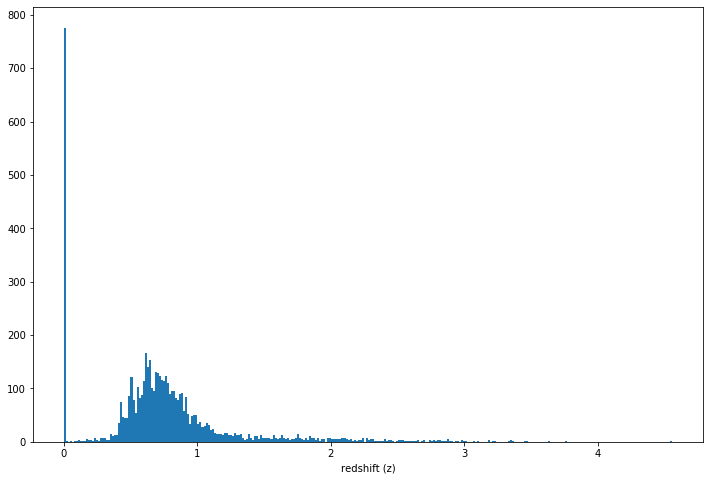

In [33]:
plt.figure(figsize=(12,8))
plt.hist(vipers_n["z"].values,bins = 300)
plt.xlabel("redshift (z)")

Text(0, 0.5, 'DEC')

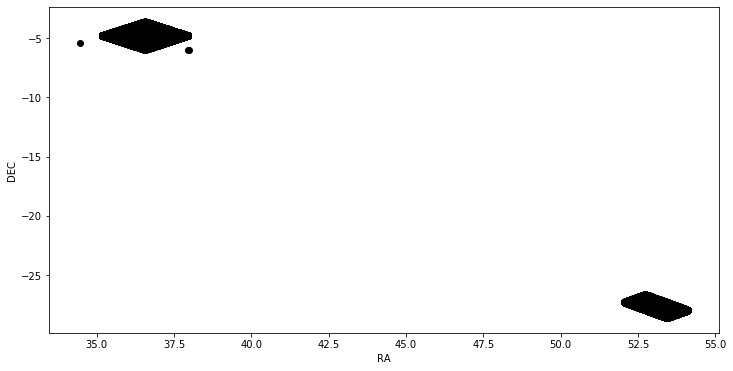

In [34]:
plt.figure(figsize=(12,6))
plt.plot(des['RA'],des['DEC'],'ko')
plt.xlabel('RA')
plt.ylabel('DEC')
#plt.xlim(0,50)
#plt.ylim(-5,5)

**Before the cleaning**

In [35]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vipers['MAG_AUTO_R'],bins = np.linspace(0,30,100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 0, 'Object in  MAG_AUTO_R')

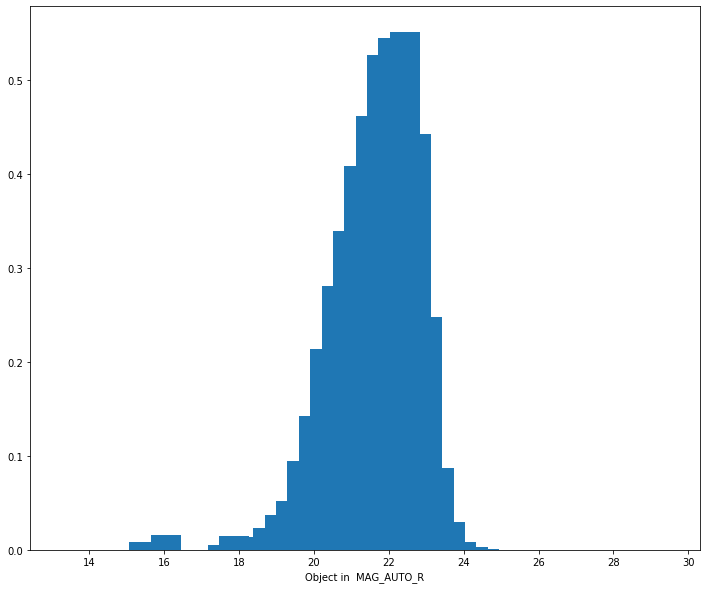

In [36]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

## Processing the data

In [37]:
vipers[vipers["MAG_AUTO_G_DERED"]>30]['MAG_AUTO_G_DERED']

203      98.911362
255      98.921722
462      98.908882
1287     98.923309
1308     98.925095
           ...    
47089    98.903145
47110    98.903465
47387    98.915062
47398    98.913086
47439    98.915985
Name: MAG_AUTO_G_DERED, Length: 217, dtype: float64

In [38]:
vipers[vipers["WAVG_MAG_PSF_G_DERED"]>30]['WAVG_MAG_PSF_G_DERED']

0        98.925415
4        98.905563
5        98.897598
6        98.906586
12       98.897285
           ...    
47641    98.921303
47648    98.920349
47653    98.925735
47654    98.925797
47657    98.926529
Name: WAVG_MAG_PSF_G_DERED, Length: 17677, dtype: float64

In [39]:
len(vipers[vipers["MAG_AUTO_G_DERED"]>30]['MAG_AUTO_G_DERED'])

217

In [40]:
feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
        'MAG_AUTO_G_DERED','MAG_AUTO_R_DERED','MAG_AUTO_I_DERED','MAG_AUTO_Z_DERED','MAG_AUTO_Y_DERED',
        "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"
       ,'WAVG_MAG_PSF_G_DERED','WAVG_MAG_PSF_R_DERED','WAVG_MAG_PSF_I_DERED','WAVG_MAG_PSF_Z_DERED','WAVG_MAG_PSF_Y_DERED']


In [41]:
for j in feat:
    print(j,":",len(vipers[(vipers[j]==99) | (vipers[j]==-99) |(vipers[j]>90)][j]),"\n")
    

MAG_AUTO_G : 209 

MAG_AUTO_R : 8 

MAG_AUTO_I : 0 

MAG_AUTO_Z : 13 

MAG_AUTO_Y : 702 

MAG_AUTO_G_DERED : 209 

MAG_AUTO_R_DERED : 8 

MAG_AUTO_I_DERED : 0 

MAG_AUTO_Z_DERED : 13 

MAG_AUTO_Y_DERED : 702 

WAVG_MAG_PSF_G : 17677 

WAVG_MAG_PSF_R : 2124 

WAVG_MAG_PSF_I : 799 

WAVG_MAG_PSF_Z : 5919 

WAVG_MAG_PSF_Y : 34481 

WAVG_MAG_PSF_G_DERED : 17677 

WAVG_MAG_PSF_R_DERED : 2124 

WAVG_MAG_PSF_I_DERED : 799 

WAVG_MAG_PSF_Z_DERED : 5919 

WAVG_MAG_PSF_Y_DERED : 34481 



In [42]:
for i in feat:
    print(i," is ",100*len(vipers[(vipers[i]==99) | (vipers[i]==-99)|(vipers[i]>90)][i])/len(vipers),"%")

MAG_AUTO_G  is  0.4385412732384909 %
MAG_AUTO_R  is  0.016786268832095348 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.027277686852154936 %
MAG_AUTO_Y  is  1.4729950900163666 %
MAG_AUTO_G_DERED  is  0.4385412732384909 %
MAG_AUTO_R_DERED  is  0.016786268832095348 %
MAG_AUTO_I_DERED  is  0.0 %
MAG_AUTO_Z_DERED  is  0.027277686852154936 %
MAG_AUTO_Y_DERED  is  1.4729950900163666 %
WAVG_MAG_PSF_G  is  37.09135926811868 %
WAVG_MAG_PSF_R  is  4.4567543749213145 %
WAVG_MAG_PSF_I  is  1.6765285996055226 %
WAVG_MAG_PSF_Z  is  12.419740652146544 %
WAVG_MAG_PSF_Y  is  72.35091694993496 %
WAVG_MAG_PSF_G_DERED  is  37.09135926811868 %
WAVG_MAG_PSF_R_DERED  is  4.4567543749213145 %
WAVG_MAG_PSF_I_DERED  is  1.6765285996055226 %
WAVG_MAG_PSF_Z_DERED  is  12.419740652146544 %
WAVG_MAG_PSF_Y_DERED  is  72.35091694993496 %


In [43]:
vipers.loc[vipers[feat[0]]==99,feat[0]] = vipers[vipers[feat[0]]!=99][feat[0]].max()
vipers.loc[vipers[feat[1]]==99,feat[1]] = vipers[vipers[feat[1]]!=99][feat[1]].max()
vipers.loc[vipers[feat[2]]==99,feat[2]] = vipers[vipers[feat[2]]!=99][feat[2]].max()
vipers.loc[vipers[feat[3]]==99,feat[3]] = vipers[vipers[feat[3]]!=99][feat[3]].max()
vipers.loc[vipers[feat[4]]==99,feat[4]] = vipers[vipers[feat[4]]!=99][feat[4]].max()

In [44]:
vipers.loc[vipers[feat[5]]>90,feat[5]] = vipers[vipers[feat[5]]<90][feat[5]].max()
vipers.loc[vipers[feat[6]]>90,feat[6]] = vipers[vipers[feat[6]]<90][feat[6]].max()
vipers.loc[vipers[feat[7]]>90,feat[7]] = vipers[vipers[feat[7]]<90][feat[7]].max()
vipers.loc[vipers[feat[8]]>90,feat[8]] = vipers[vipers[feat[8]]<90][feat[8]].max()
vipers.loc[vipers[feat[9]]>90,feat[9]] = vipers[vipers[feat[9]]<90][feat[9]].max()

In [45]:
vipers.loc[vipers[feat[10]]>90,feat[10]] = vipers[vipers[feat[10]]<90][feat[10]].max()
vipers.loc[vipers[feat[11]]>90,feat[11]] = vipers[vipers[feat[11]]<90][feat[11]].max()
vipers.loc[vipers[feat[12]]>90,feat[12]] = vipers[vipers[feat[12]]<90][feat[12]].max()
vipers.loc[vipers[feat[13]]>90,feat[13]] = vipers[vipers[feat[13]]<90][feat[13]].max()
vipers.loc[vipers[feat[14]]>90,feat[14]] = vipers[vipers[feat[14]]<90][feat[14]].max()

In [46]:
vipers.loc[vipers[feat[15]]>90,feat[15]] = vipers[vipers[feat[15]]<90][feat[15]].max()
vipers.loc[vipers[feat[16]]>90,feat[16]] = vipers[vipers[feat[16]]<90][feat[16]].max()
vipers.loc[vipers[feat[17]]>90,feat[17]] = vipers[vipers[feat[17]]<90][feat[17]].max()
vipers.loc[vipers[feat[18]]>90,feat[18]] = vipers[vipers[feat[18]]<90][feat[18]].max()
vipers.loc[vipers[feat[19]]>90,feat[19]] = vipers[vipers[feat[19]]<90][feat[19]].max()

In [47]:
for i in feat:
    print(i," is ",100*len(vipers[(vipers[i]==99) | (vipers[i]==-99) | (vipers[i]>90)][i])/len(vipers),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.0 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.0 %
MAG_AUTO_Y  is  0.0 %
MAG_AUTO_G_DERED  is  0.0 %
MAG_AUTO_R_DERED  is  0.0 %
MAG_AUTO_I_DERED  is  0.0 %
MAG_AUTO_Z_DERED  is  0.0 %
MAG_AUTO_Y_DERED  is  0.0 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %
WAVG_MAG_PSF_G_DERED  is  0.0 %
WAVG_MAG_PSF_R_DERED  is  0.0 %
WAVG_MAG_PSF_I_DERED  is  0.0 %
WAVG_MAG_PSF_Z_DERED  is  0.0 %
WAVG_MAG_PSF_Y_DERED  is  0.0 %


In [48]:
print("With this choice we maintain",100*(len(vipers)/originalTam),"%")

With this choice we maintain 100.0 %


## Plots

In [49]:
count1, n1 = np.histogram(des['MAG_AUTO_R_DERED'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vipers['MAG_AUTO_R_DERED'],bins = np.linspace(0,30,100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 0, 'Object in  MAG_AUTO_R_DERED')

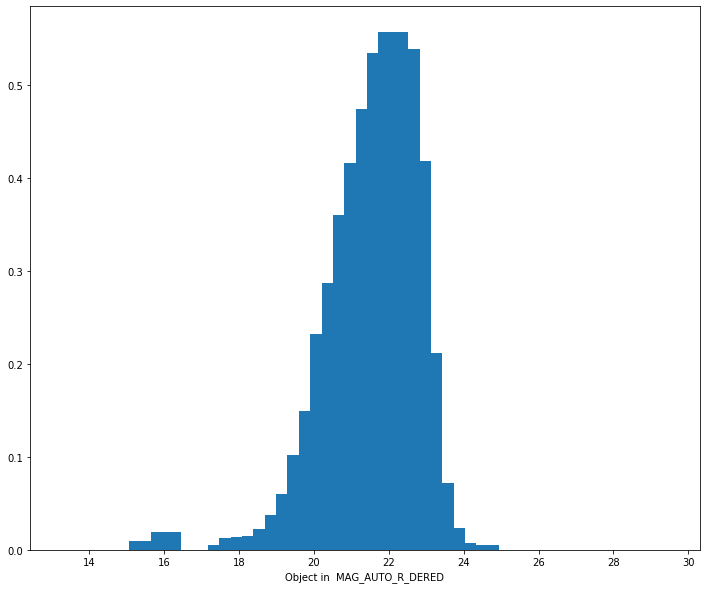

In [50]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R_DERED")
#plt.ylim(0.8)

Text(0.5, 0, 'redshift')

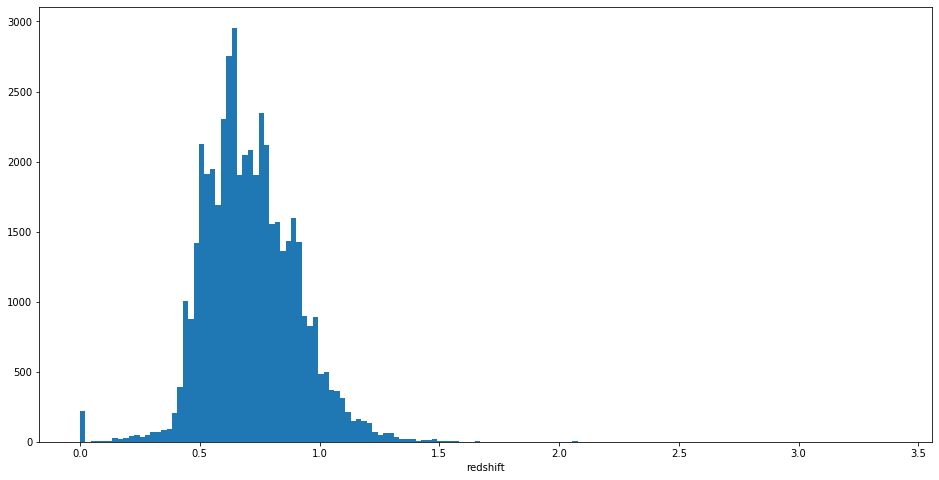

In [51]:
plt.figure(figsize=(16,8))
plt.hist(vipers["z"],bins= 150)
plt.xlabel("redshift")

In [52]:
feat.append("z")

<Figure size 2880x2304 with 0 Axes>

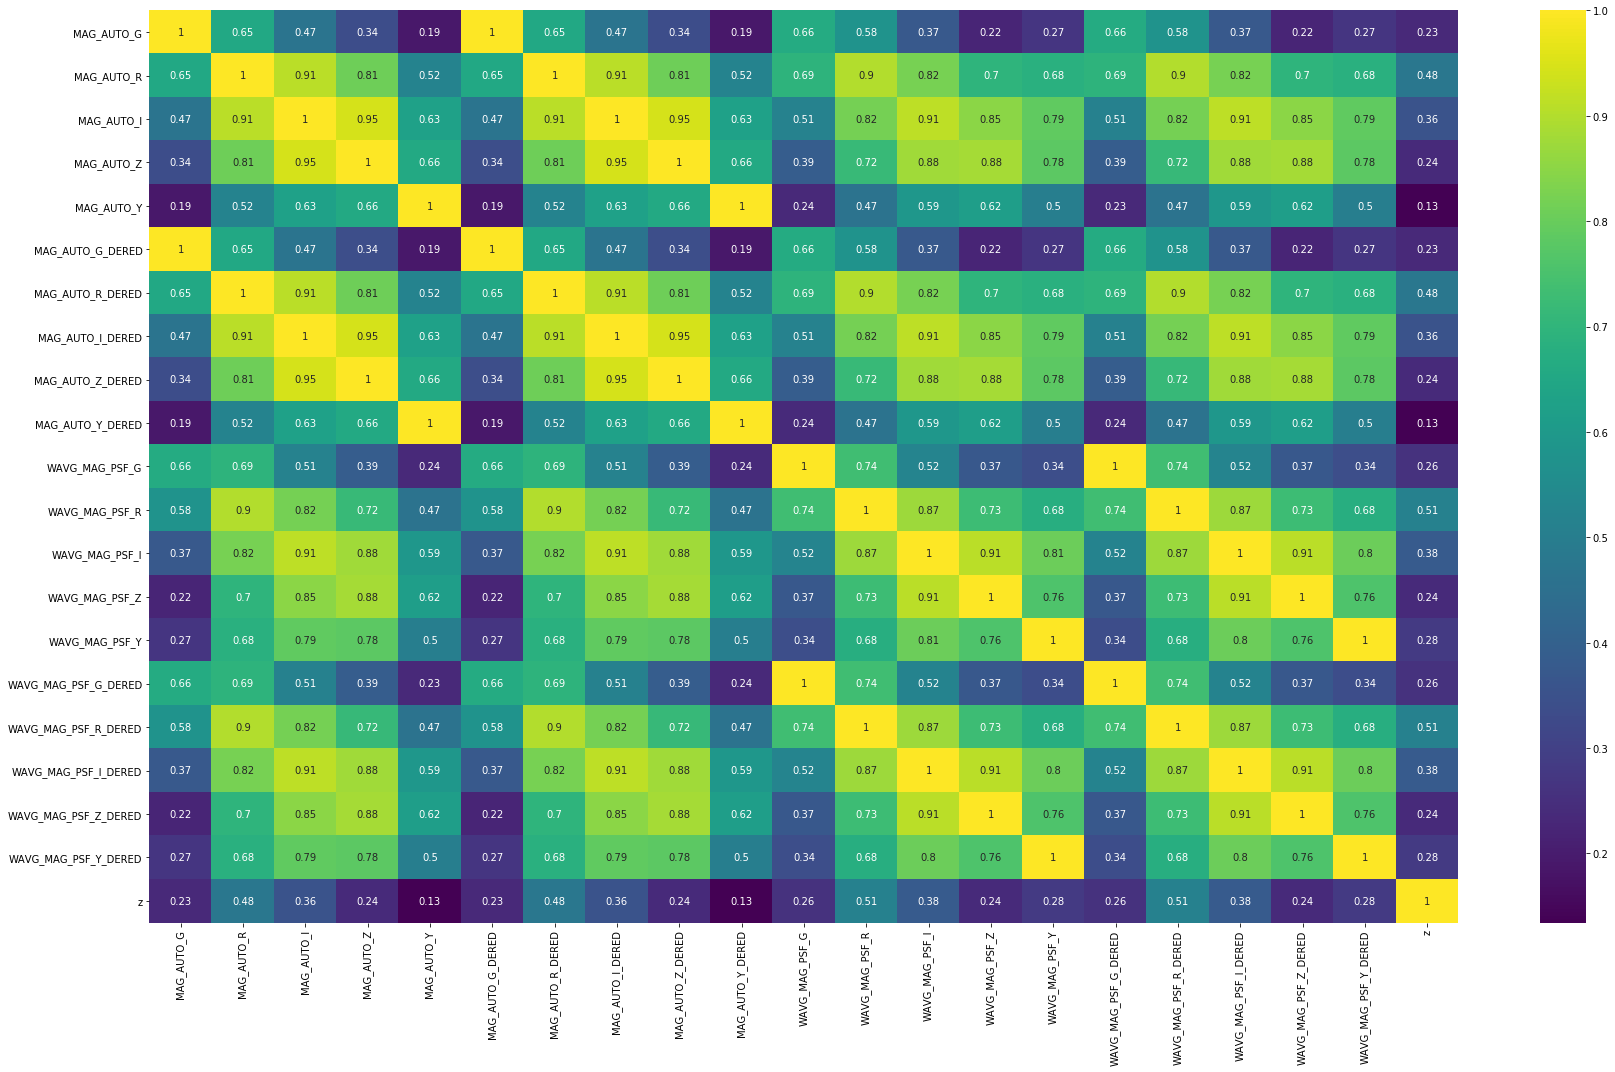

In [53]:
plt.figure(figsize=(40,32))
corrmat = vipers[feat].corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

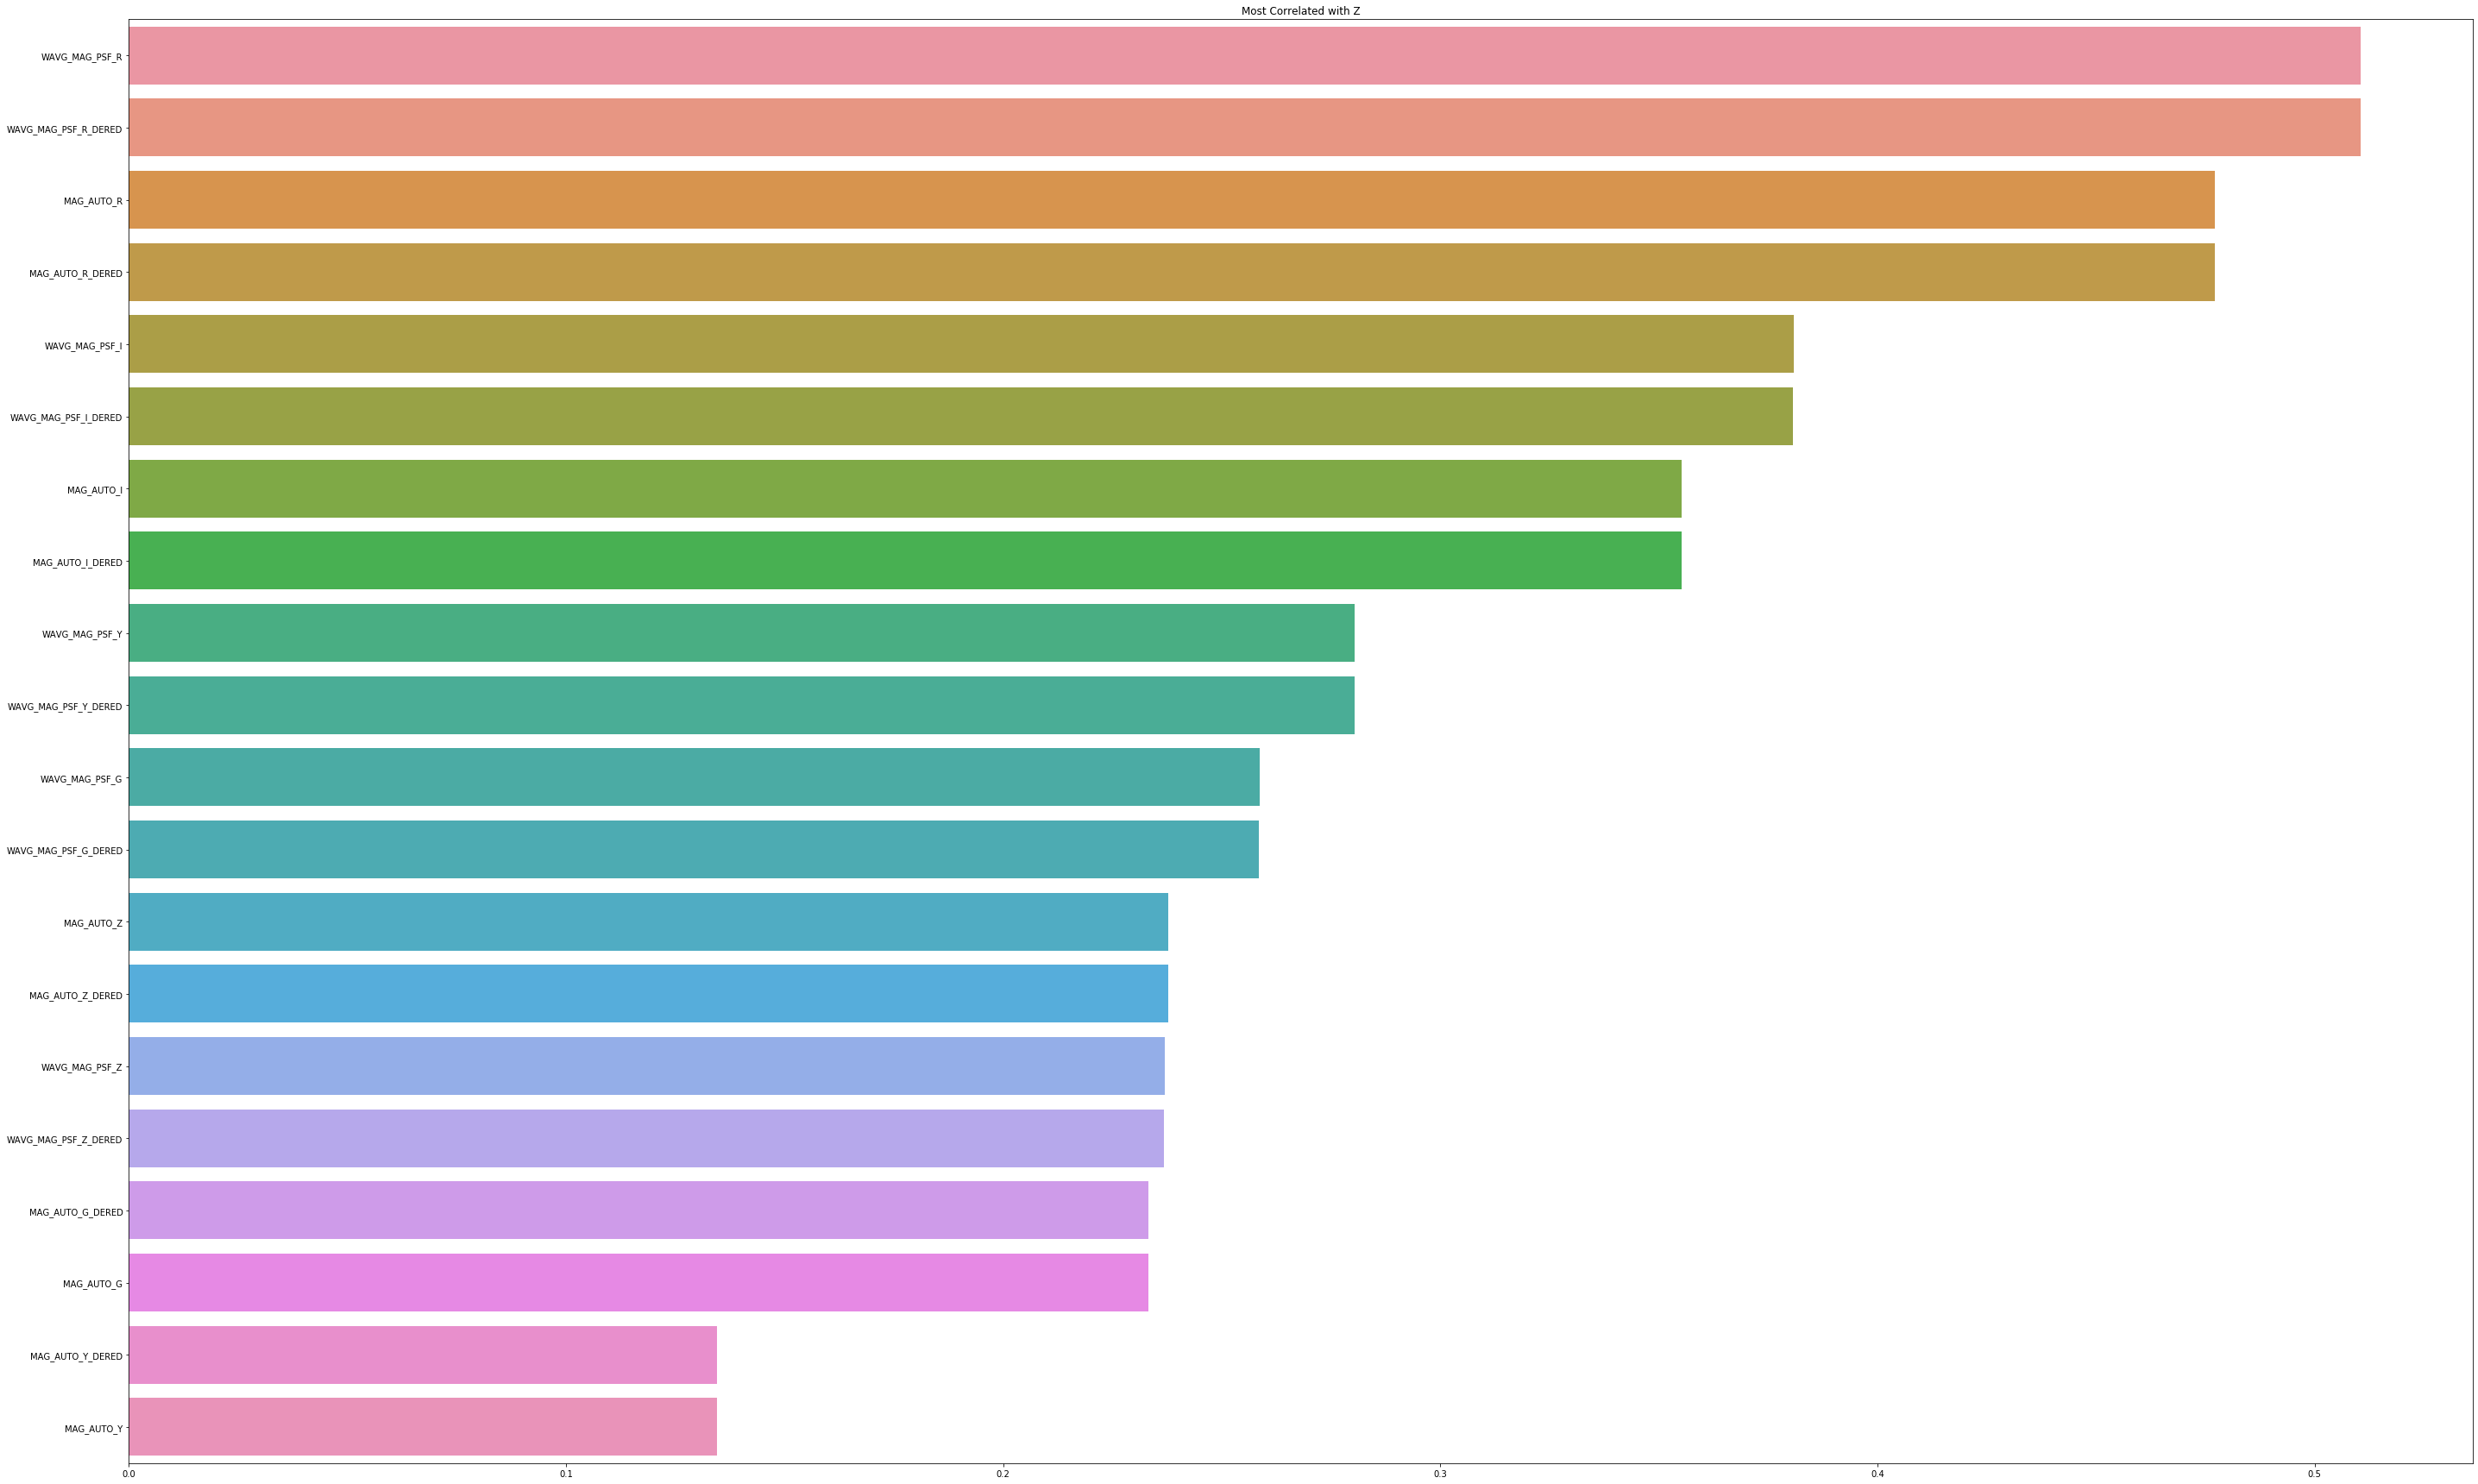

In [54]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()
plt.savefig("correlations.png",dpi = 500,bbox_inches = "tight" )

<Figure size 1152x576 with 0 Axes>

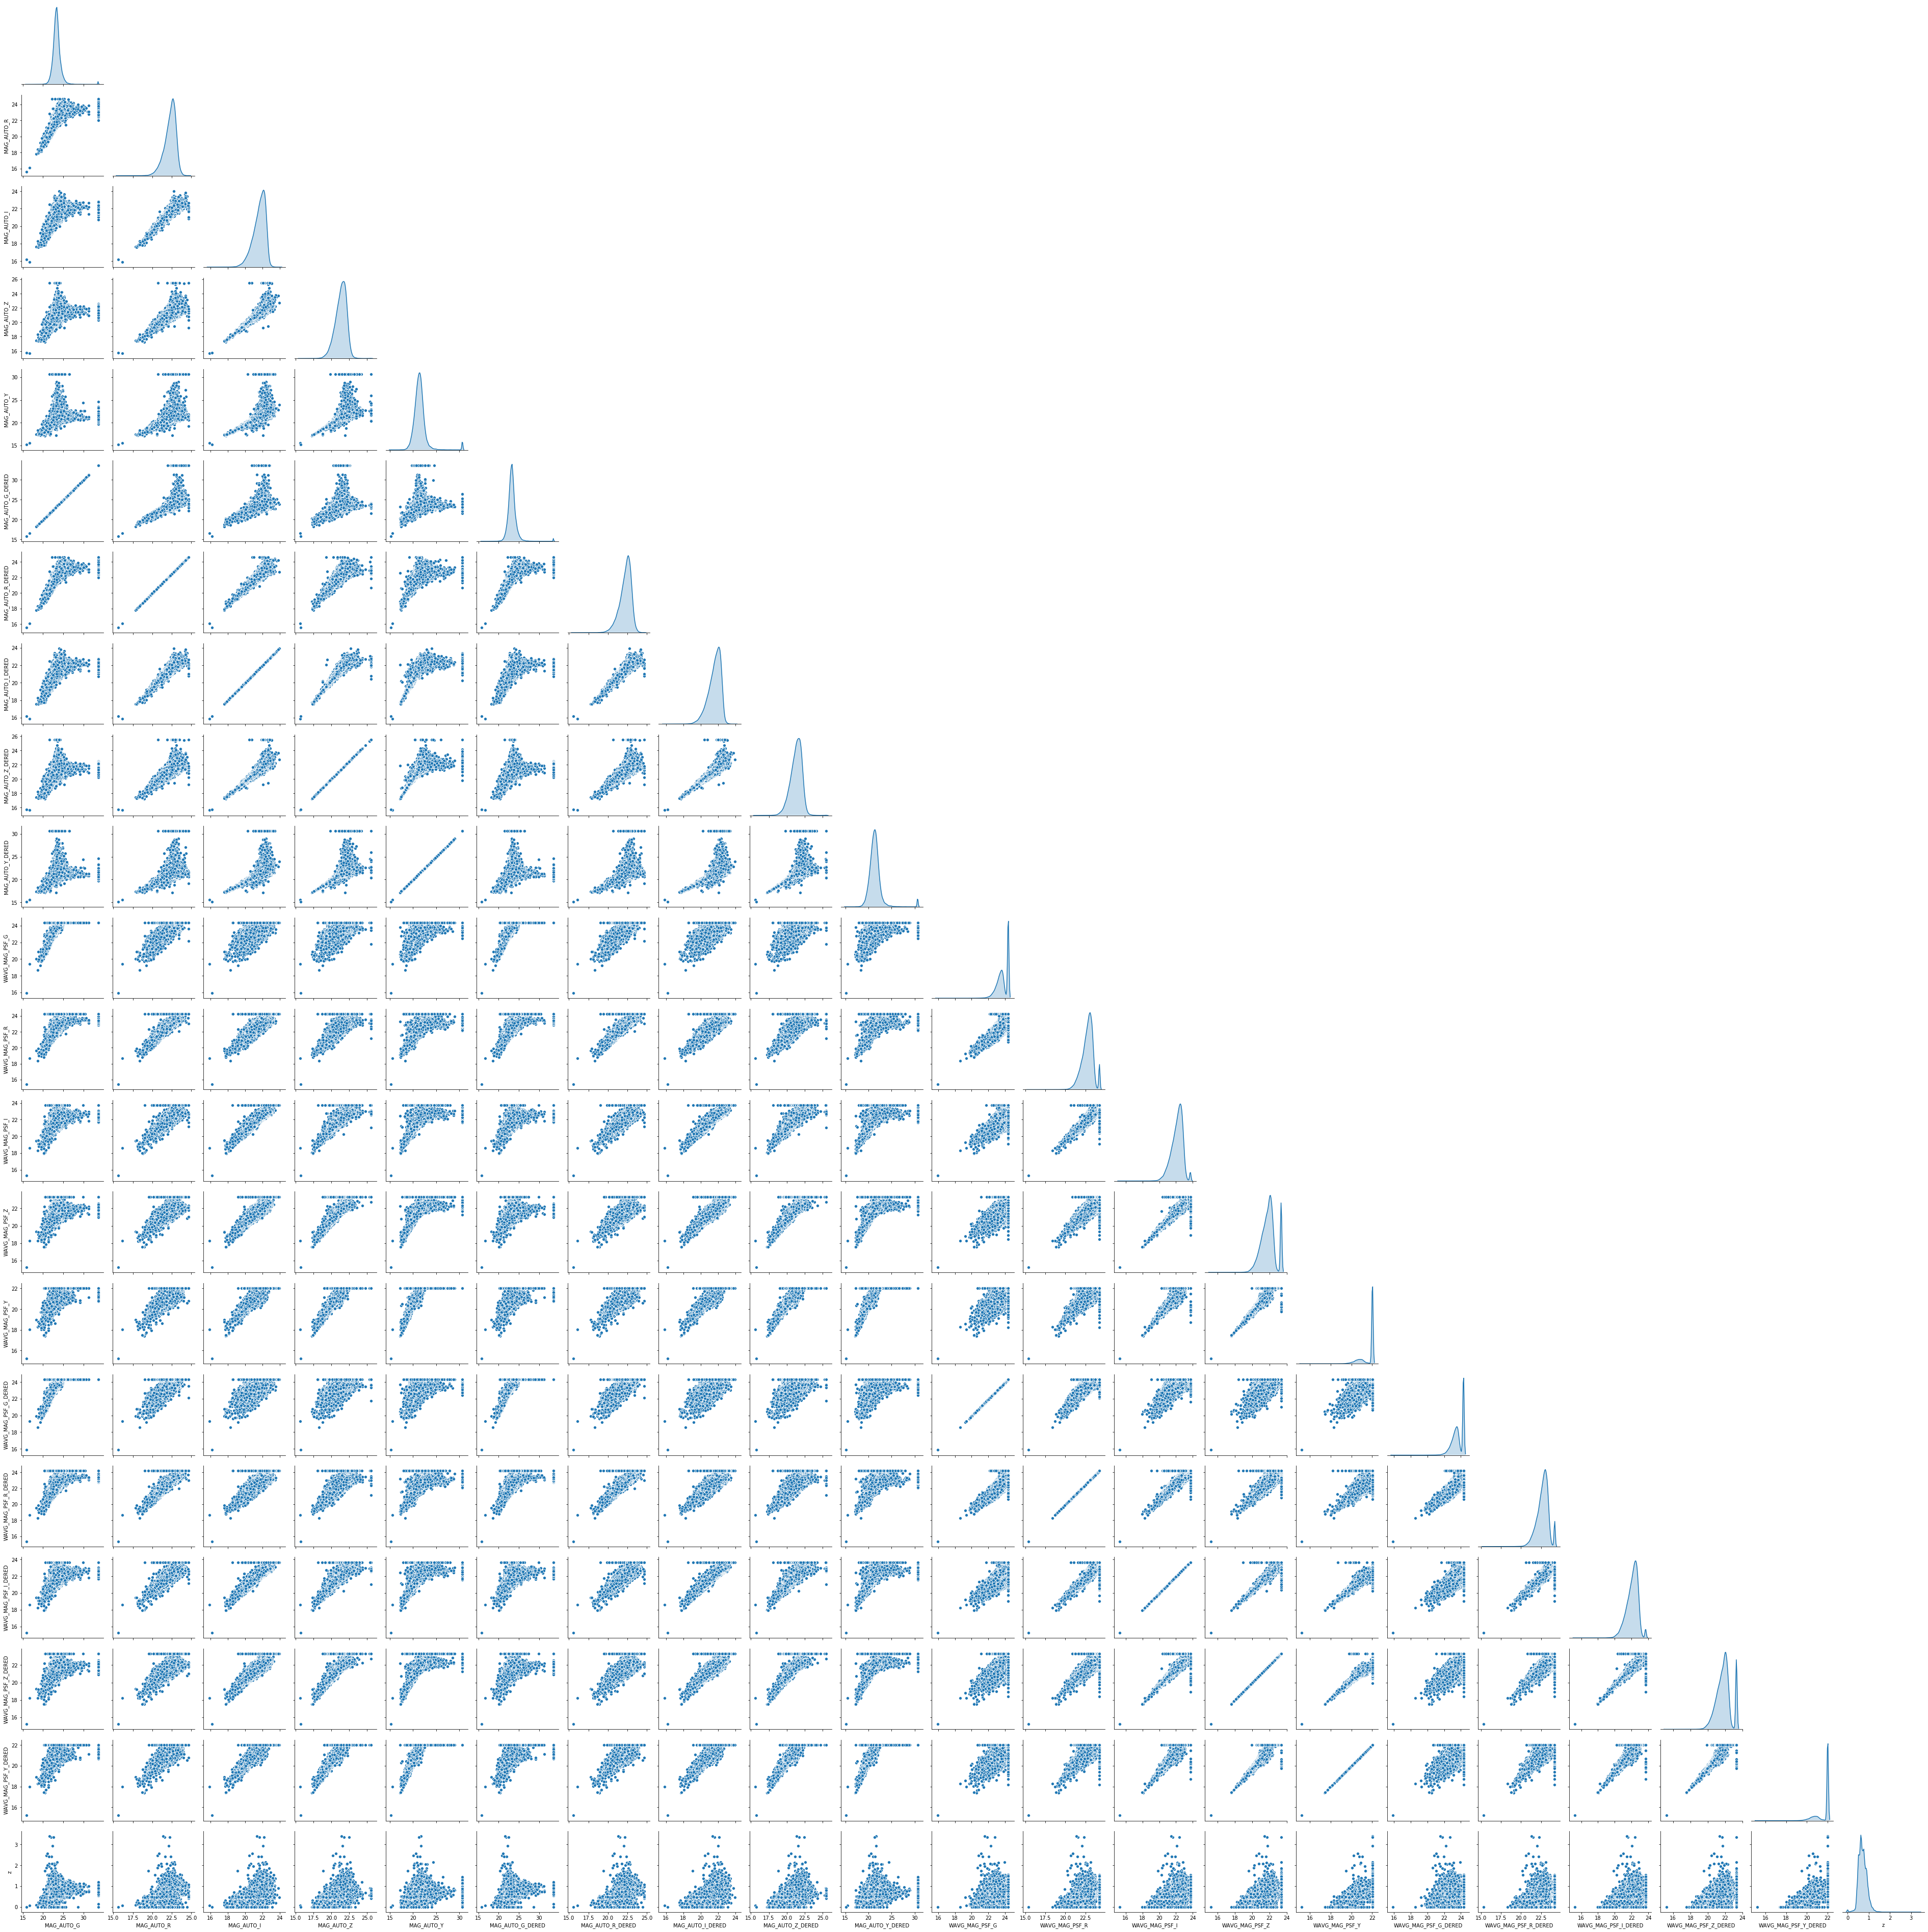

In [55]:
plt.figure(figsize=(16,8))
sns.pairplot(vipers[feat],diag_kind= "kde",corner= True)

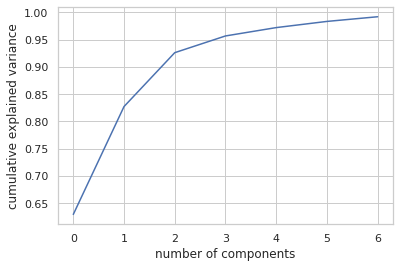

None

Cumulative Variance Ratio  Explained Variance Ratio
0                   0.629442                  0.629442
1                   0.827330                  0.197888
2                   0.926181                  0.098852
3                   0.956837                  0.030656
4                   0.972169                  0.015332
5                   0.983506                  0.011337
6                   0.992080                  0.008574

In [56]:
pca_test = PCA(n_components=7)
pca_test.fit(vipers[feat[0:19]])
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=2, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [57]:
pca = PCA(n_components=5)
new_feat = pca.fit_transform(vipers[feat[0:19]])
new_components = pd.DataFrame(new_feat,columns=["1 Component","2 Component","3 Component","4 Component","5 Component"])
new_components["z"] = vipers["z"]
new_components.head()

1 Component  2 Component  3 Component  4 Component  5 Component       z
0    -3.652719     0.092932    -1.101496     0.958834     0.469344  0.8625
1    -0.360279    -0.400621    -0.310583    -0.502245    -0.339501  0.8799
2     4.884583    -0.065155     0.546440     0.700493     0.568622  0.5614
3     1.189527    -0.237561    -0.714585     0.301262     0.293826  0.8175
4    -1.932063     2.097695     0.225255     0.281152    -0.934492  0.9880

<Figure size 1152x864 with 0 Axes>

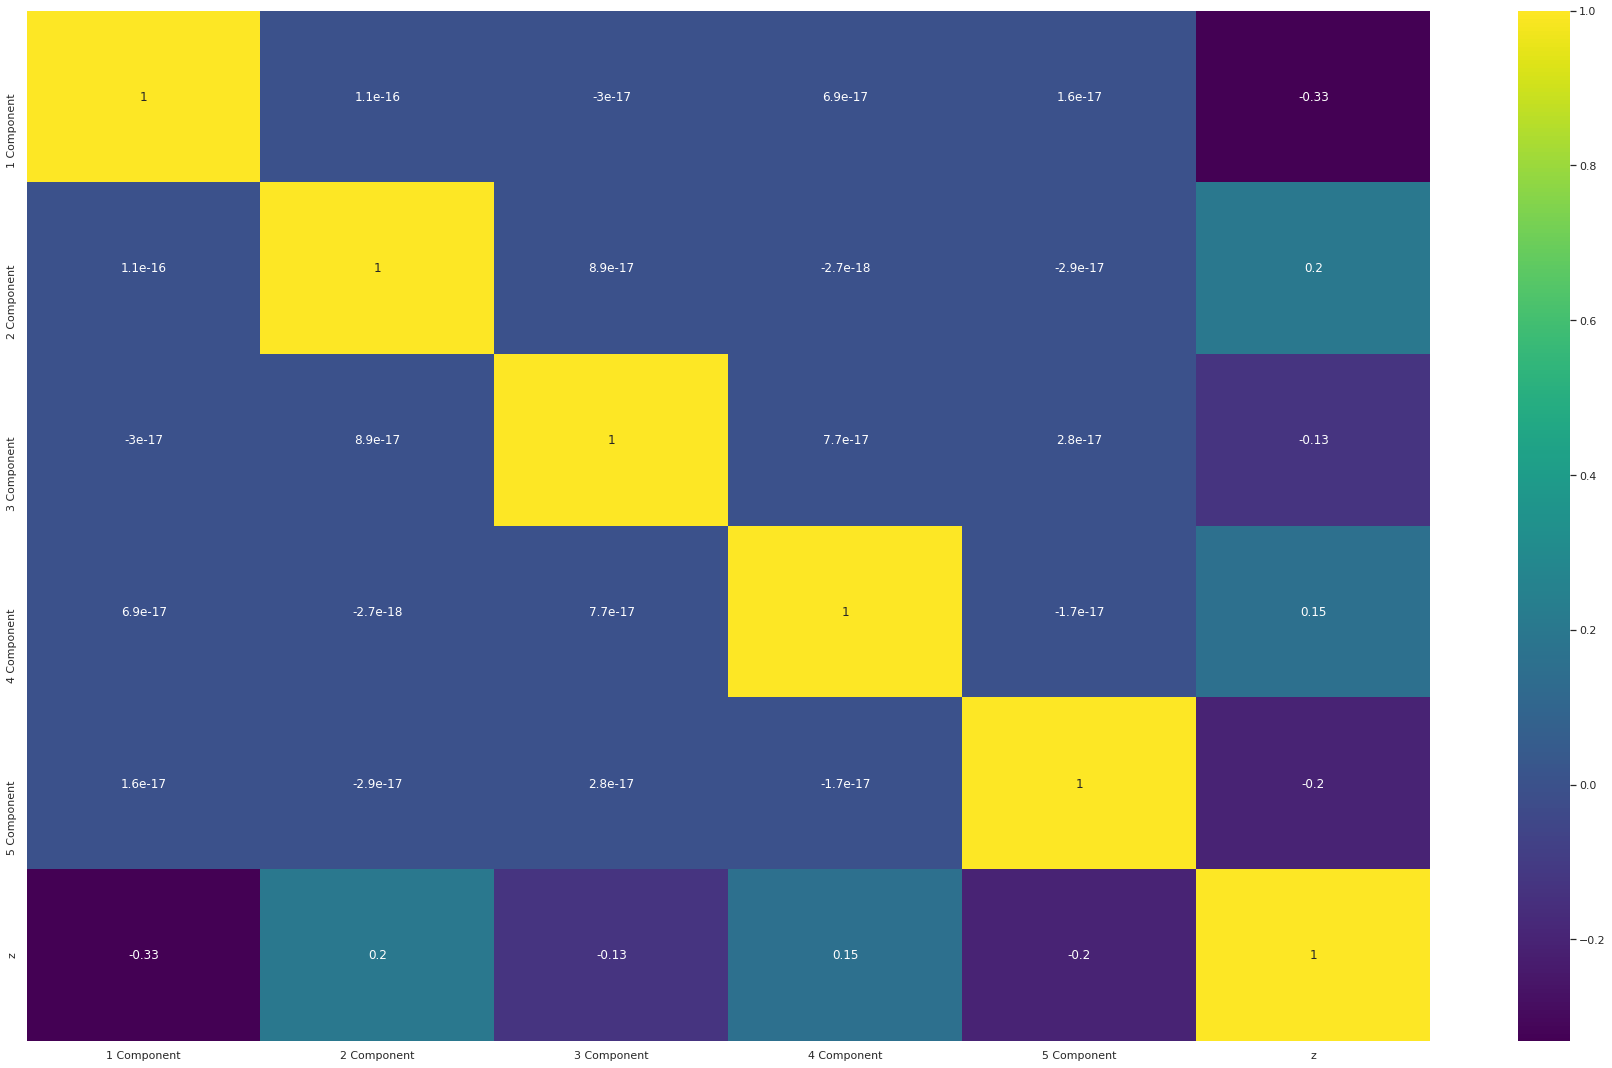

In [58]:
plt.figure(figsize=(16,12))
corrmat1 = new_components.corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat1,annot=True,cmap="viridis")
plt.tight_layout()

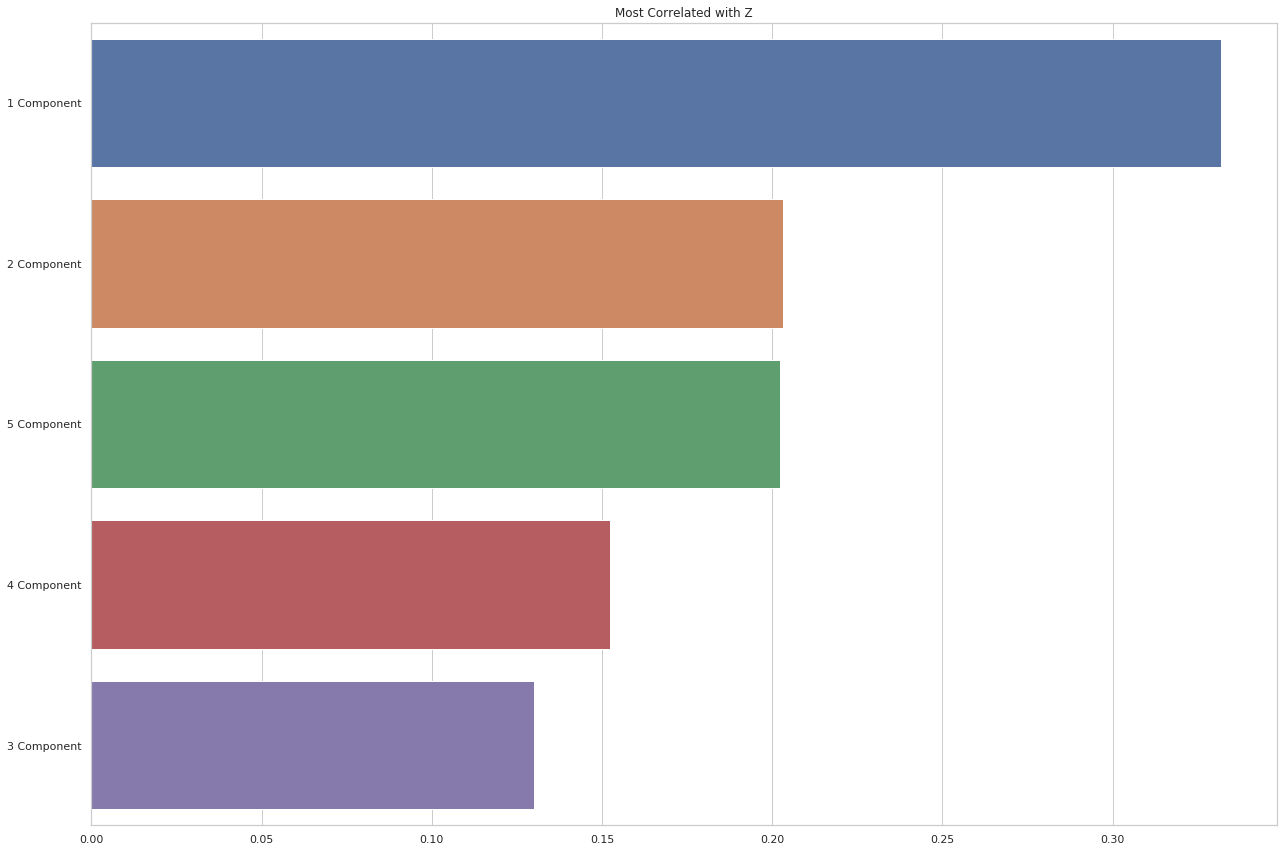

In [59]:
plt.figure(figsize=(18,12))
correlations =corrmat1.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()

<Figure size 1152x576 with 0 Axes>

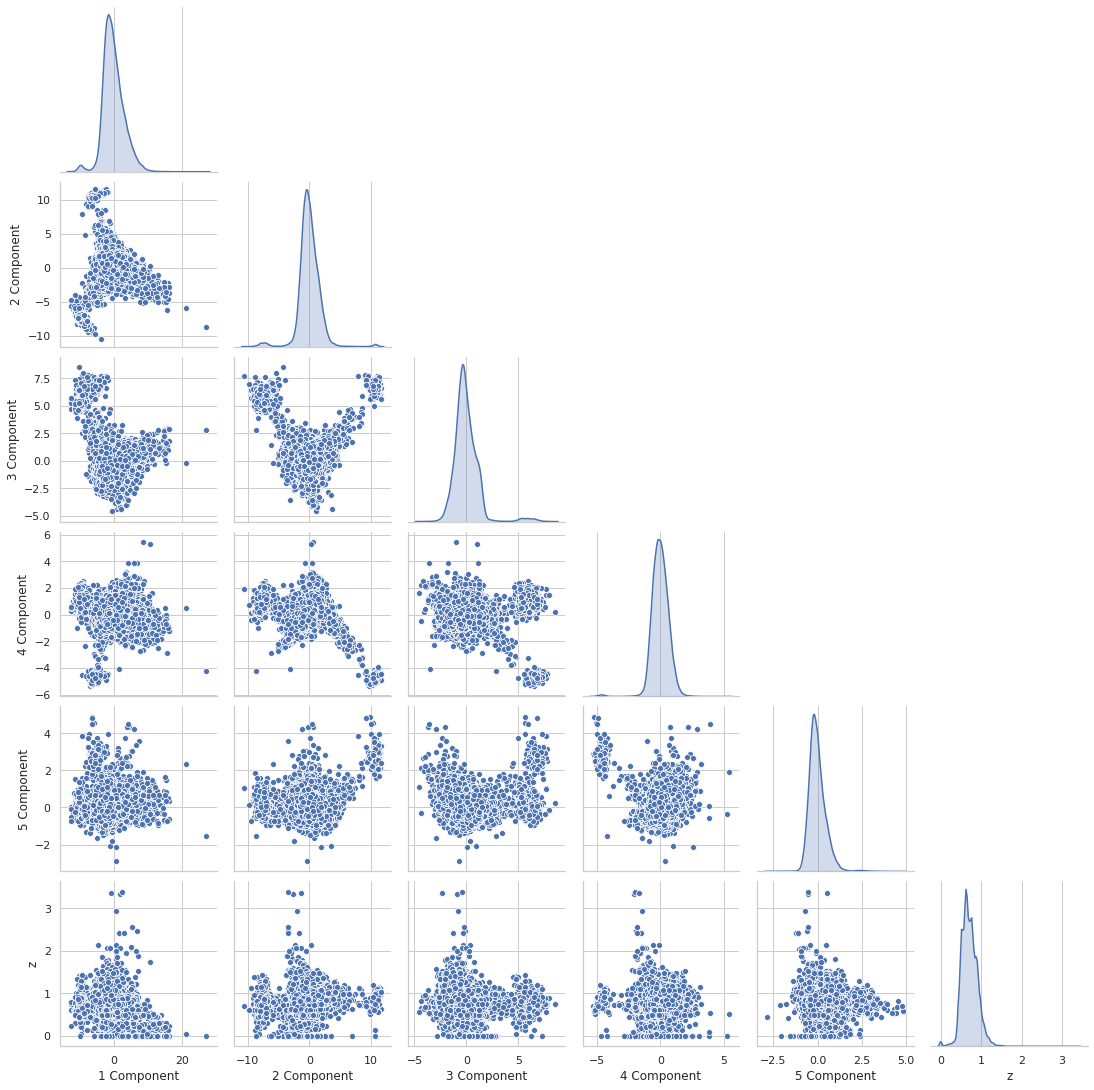

In [60]:
plt.figure(figsize=(16,8))
sns.pairplot(new_components,diag_kind= "kde",corner= True)

## Machine Learning

In [52]:
X,y = get_features_targets2(vipers)

In [53]:
X = np.concatenate((X,vipers["MAG_AUTO_I_DERED"].values.reshape(-1,1)),axis = 1)

In [54]:
X_train,X_test,y_train,y_test = tts_split(X,y,0.3)

### Plots of the features

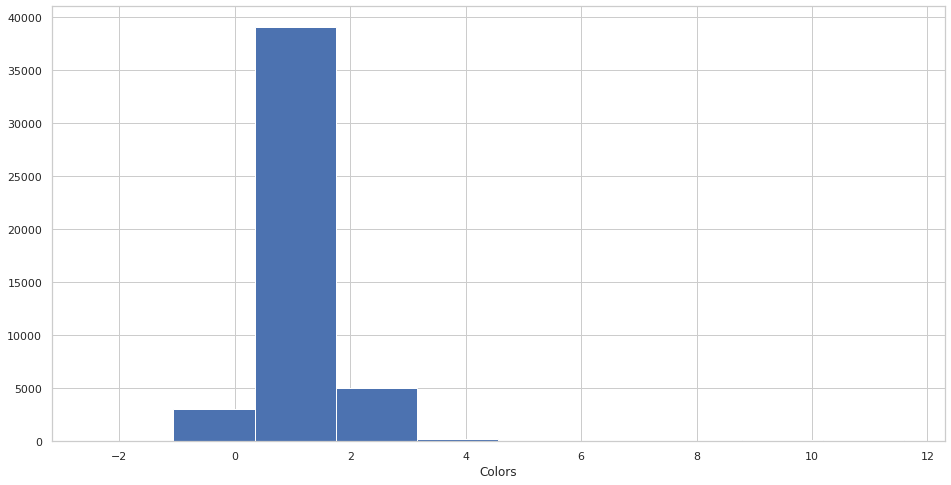

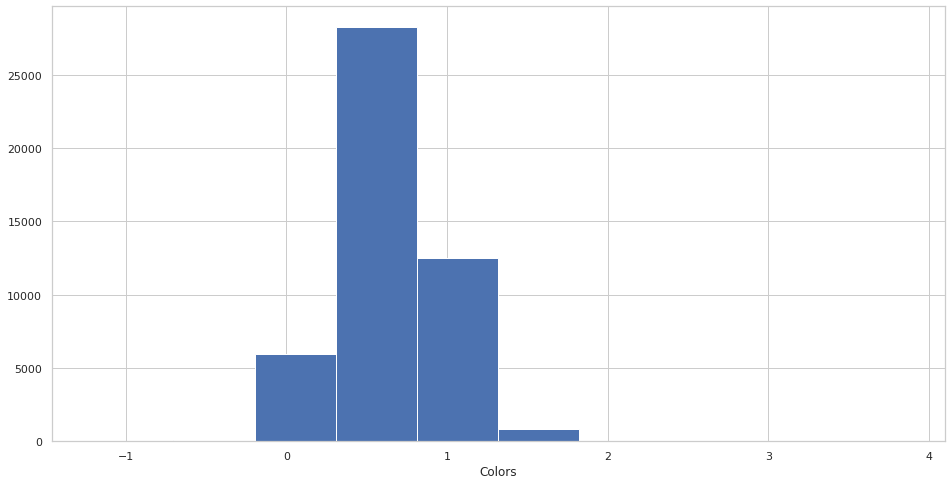

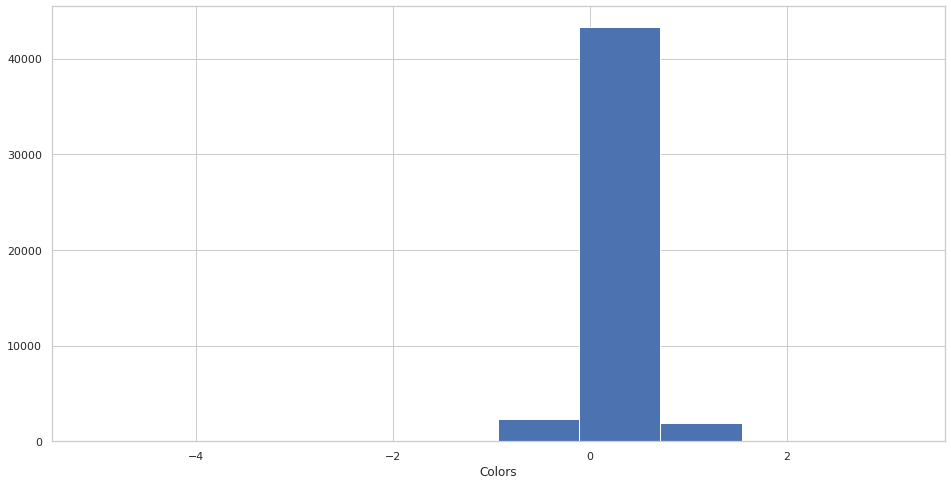

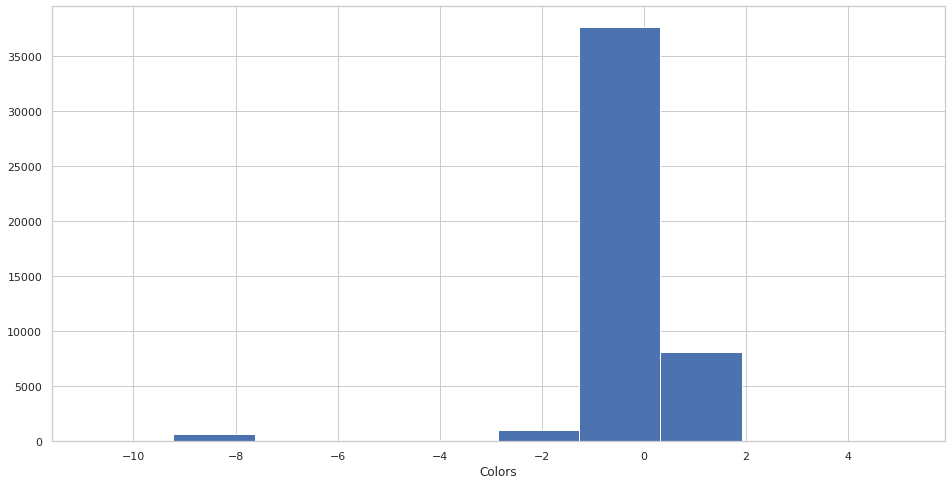

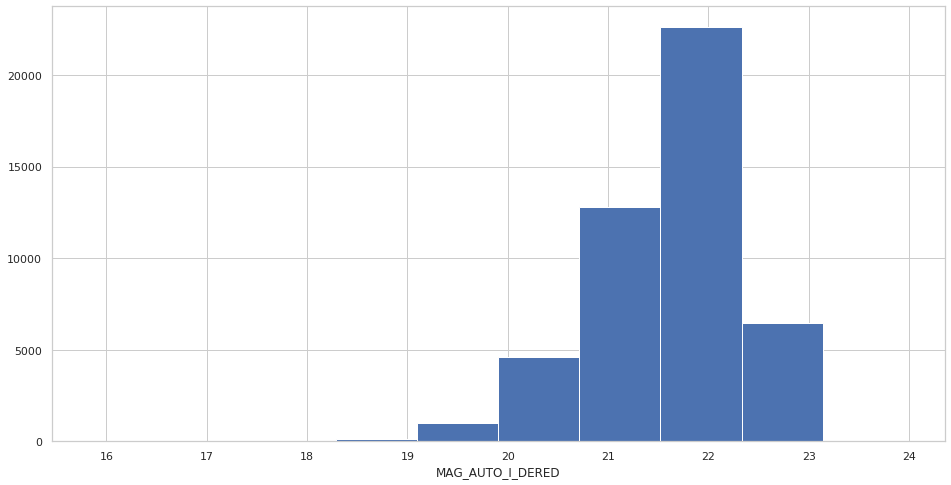

In [64]:
for i in range(5):
    plt.figure(figsize = (16,8))
    plt.hist(X[:,i])
    if i == 4:
        plt.xlabel("MAG_AUTO_I_DERED")
    else:
        plt.xlabel("Colors")
    

Text(0.5, 0, 'Redshift Train')

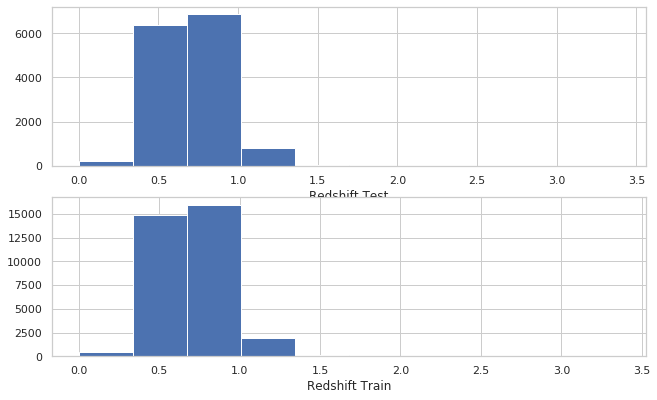

In [65]:
fig = plt.figure()
grid = plt.GridSpec(3,2, top = 2,right = 1.5)
ax = plt.subplot(grid[0,:])
plt.hist(y_test)
plt.xlabel("Redshift Test")

ax = plt.subplot(grid[1,:])
plt.hist(y_train)
plt.xlabel("Redshift Train")



### Tuning Algorithms

In [66]:
params_dict = {
            'KNeighborsRegressor': {'n_neighbors':list(range(3, 11))},
            'SVR' : {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.3]},
            'SGDRegressor': {'alpha': 10.0 ** -np.arange(1, 10), 'penalty': ['l2', 'l1', 'elasticnet'], 'learning_rate': ['constant', 'optimal', 'invscaling']},
            'RandomForestRegressor' : {"n_estimators": list(range(100,500,50)) ,"min_samples_split": list(range(2,50,2)), "max_depth": list(range(2,20,2)) },
            'DecisionTreeRegressor' : {"criterion":['mse', 'friedman_mse', 'mae', 'poisson'],"splitter" : ["best","random"],"min_samples_split": list(range(2,50,2)), "max_depth": list(range(2,20,2)) },
            'Lasso'                 :{"max_iter": list(range(200,1000,300)),"selection" :["cyclic","random"]},
            'ElasticNet'            :{"alpha ": 10.0 ** -np.arange(1, 10),"l1_ratio" : 10.0 ** -np.arange(0, 10) ,"max_iter": list(range(200,1000,300)),"selection" :["cyclic","random"]},
            'KernelRidge'           :{'alpha': 10.0 ** -np.arange(1, 10),"degree" :[1,2,3,4,5,6,7,8,9],'coef0' : [1,2,3,4,5,6,7,8,9,]},
            'GradientBoostingRegressor' : {'loss' : ['ls', 'lad', 'huber', 'quantile'],"learning_rate": 10.0 ** -np.arange(1, 10),'n_estimators':list(range(200,1000,300)),"criterion":["friedman_mse", "mse", "mae"],"max_features":["auto","sqrt","log2"]},
  
}
            


In [67]:
best_models = []

            
KNNR = KNeighborsRegressor()
SVR = SVR()
SGDR = SGDRegressor()
RFR = RandomForestRegressor()
LAS = Lasso()
ElcNet = ElasticNet()
KRR = KernelRidge()
GBoost = GradientBoostingRegressor()
DTR = DecisionTreeRegressor()
algorithms = [KNNR,SVR,SGDR,RFR,DTR,LAS,KRR,GBoost]
#algorithms = [RFR,DTR,GBoost]

In [68]:
# best_models = [] 
for algorithm in algorithms:
    clf = GridSearchCV(estimator=algorithm, param_grid=params_dict['{}'.format(algorithm.__class__.__name__)], cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    clf.fit(X_train[0:3000], y_train[0:3000].ravel())
    best_models.append(clf.best_estimator_)
        

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.0s finished


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 out of 243 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    0.6s finished


Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4920 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed:  5.0min finished


Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 2240 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4040 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed:  1.3min finished


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 2916 out of 2916 | elapsed: 29.9min finished


In [69]:
evaluation = []
for model in best_models:
    
    predictions = model.predict(X_test)
    evaluation.append(mean_squared_error(y_test, predictions))
evaluation

[0.019055283,
 0.025241254634089424,
 2.4187724344608954,
 0.017622647099880394,
 0.02135519107993019,
 0.037198925805462885,
 0.027537591772703738,
 0.017585599750995825]

In [70]:
best_models

[KNeighborsRegressor(n_neighbors=9),
 SVR(C=10, epsilon=0.2, gamma=1e-07, kernel='linear'),
 SGDRegressor(alpha=1e-06, penalty='elasticnet'),
 RandomForestRegressor(max_depth=18, min_samples_split=34),
 DecisionTreeRegressor(criterion='mae', max_depth=18, min_samples_split=36,
                       splitter='random'),
 Lasso(max_iter=200),
 KernelRidge(alpha=1e-08, degree=1),
 GradientBoostingRegressor(criterion='mae', loss='lad', max_features='sqrt',
                           n_estimators=500)]

In [55]:
# Here are some hyper-tuning algorithims, in case if you wanto to use
new_models = [ KNeighborsRegressor(n_neighbors=10),
 SGDRegressor(alpha=0.01),
 RandomForestRegressor(max_depth=18, min_samples_split=28),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                       min_samples_split=32, splitter='random'),
 Lasso(max_iter=200),
 KernelRidge(alpha=1e-08, degree=1),
 GradientBoostingRegressor(criterion='mae', loss='lad', max_features='sqrt',
                           n_estimators=200)]

In [72]:
params_dict2 = {'AdaBoostRegressor': {"base_estimator": best_models[4:6],"n_estimators": list(range(100,500,100)),"learning_rate" : 10.0 ** -np.arange(0, 7), "loss" :['linear', 'square', 'exponential']},
            'BaggingRegressor': {"base_estimator": best_models[4:6],"n_estimators": list(range(100,500,100)),"n_jobs" : [-1]}
            }

In [73]:
algorithms = [AdaBoostRegressor(),BaggingRegressor()]

In [74]:
best_models2 = [] 
for algorithm in algorithms:
    clf = GridSearchCV(estimator=algorithm, param_grid=params_dict2['{}'.format(algorithm.__class__.__name__)], cv=3, scoring='neg_mean_squared_error', n_jobs=35, verbose=1)
    clf.fit(X_train[0:2500], y_train[0:2500].ravel())
    best_models2.append(clf.best_estimator_)
        

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 130 tasks      | elapsed:   50.9s
[Parallel(n_jobs=35)]: Done 380 tasks      | elapsed:  1.5min
[Parallel(n_jobs=35)]: Done 504 out of 504 | elapsed:  1.6min finished


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   5 out of  24 | elapsed:    1.4s remaining:    5.2s
[Parallel(n_jobs=35)]: Done  24 out of  24 | elapsed:    5.6s finished


In [75]:
evaluation2 = []
for model in best_models2:
    predictions = model.predict(X_test)
    evaluation2.append(mean_squared_error(y_test, predictions))
evaluation2

[0.017418046872472438, 0.01767656739158792]

In [76]:
best_models2

[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                        max_depth=18,
                                                        min_samples_split=36,
                                                        splitter='random'),
                   learning_rate=0.01, loss='exponential', n_estimators=400),
 BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       max_depth=18,
                                                       min_samples_split=36,
                                                       splitter='random'),
                  n_estimators=300, n_jobs=-1)]

### ANN model


In [56]:
EarlyStop = EarlyStopping(monitor='rmse_ann', mode='min', patience=5)
n_inputs = X_train.shape[1]


In [57]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [58]:
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                        
                       Dense(8, kernel_initializer='normal',  kernel_constraint=max_norm(2.) ,activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       BatchNormalization(),
                       Dense(8,kernel_initializer='normal', kernel_constraint=max_norm(2.) ,activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])
opt = ks.optimizers.RMSprop(lr_schedule)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann, metrics=['mse', 'mae', 'mape',rmse_ann])

In [59]:
history = ann_model.fit(X_train, y_train, epochs=70,batch_size=64, validation_split=0.2, callbacks=[EarlyStop])

Epoch 1/70
417/417 [==============================] - 2s 3ms/step - loss: 0.2561 - mse: 0.1340 - mae: 0.2559 - mape: 2681268.5680 - rmse_ann: 0.2559 - val_loss: 0.1627 - val_mse: 0.0481 - val_mae: 0.1625 - val_mape: 2513413.5000 - val_rmse_ann: 0.1625
Epoch 2/70
417/417 [==============================] - 1s 2ms/step - loss: 0.1058 - mse: 0.0287 - mae: 0.1055 - mape: 3460691.2179 - rmse_ann: 0.1055 - val_loss: 0.6222 - val_mse: 0.4129 - val_mae: 0.6220 - val_mape: 436830.6875 - val_rmse_ann: 0.6220
Epoch 3/70
417/417 [==============================] - 1s 2ms/step - loss: 0.1054 - mse: 0.0274 - mae: 0.1052 - mape: 3599407.0769 - rmse_ann: 0.1052 - val_loss: 0.6050 - val_mse: 0.3864 - val_mae: 0.6048 - val_mape: 477910.1250 - val_rmse_ann: 0.6048
Epoch 4/70
417/417 [==============================] - 1s 2ms/step - loss: 0.1006 - mse: 0.0231 - mae: 0.1004 - mape: 3496904.4772 - rmse_ann: 0.1004 - val_loss: 0.1246 - val_mse: 0.0314 - val_mae: 0.1244 - val_mape: 2532232.5000 - val_rmse_ann: 0

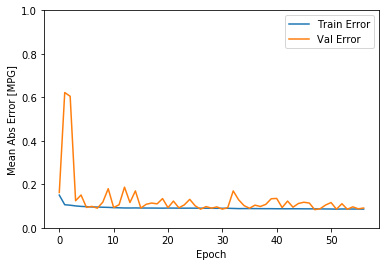

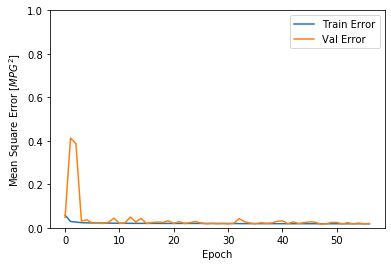

In [60]:
plot_history(history)

In [61]:
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann))

447/447 [==============================] - 1s 1ms/step - loss: 0.0930 - mse: 0.0199 - mae: 0.0924 - mape: 2544972.2500 - rmse_ann: 0.0924
Testing set Mean Abs Error:  0.02 


Testing set Root Mean Abs Error:  0.09 


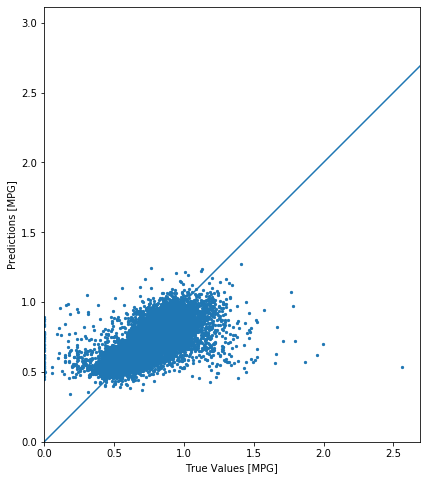

In [62]:
test_predictions = ann_model.predict(X_test).flatten()

plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=5)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Text(0, 0.5, 'Frequency')

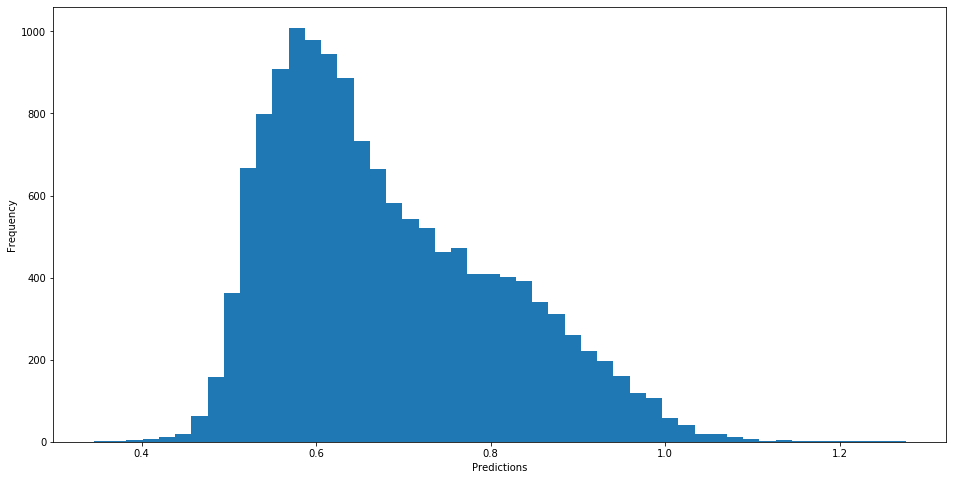

In [63]:
plt.figure(figsize=(16,8))
plt.hist(test_predictions,bins = 50)
plt.xlabel('Predictions')
plt.ylabel('Frequency')

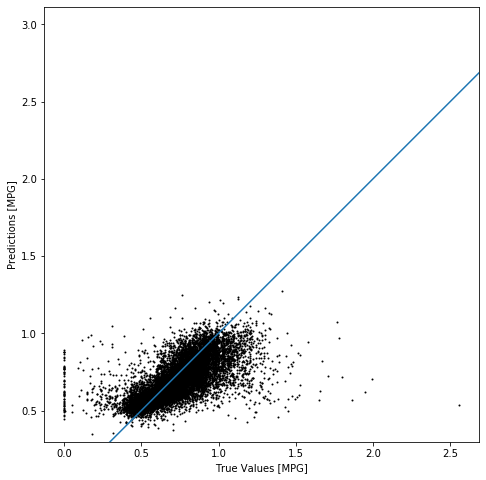

In [64]:
plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=1,c = "k")
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])


### Bayesian Neural nets

In [65]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [66]:
# define the loss function as negative log likellyhood


def nll(y_true,y_pred):
    return -y_pred.log_prob(y_true)

def prior(kernel_size,bias_size,dtype = None):
    n = kernel_size+bias_size #number of weigths
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n),scale_diag = tf.ones(n))
        )
    ])
    return prior_model

def posterior (kernel_size,bias_size,dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
            
    ])
    return posterior_model


In [67]:
EarlyStop = EarlyStopping(monitor='rmse_ann2', mode='min', patience=10)
n_inputs = X_train.shape[1]
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q,p) / X_train.shape[0]

# Build model.
model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                    
                     tfpl.DenseVariational(units=10,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],activation =  "tanh"),
                    BatchNormalization(),
                    tfpl.DenseVariational(units=10,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],activation =  "tanh"),
                    
                    tfpl.DenseReparameterization( units = tfpl.IndependentNormal.params_size(1), activation=None,                                                
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
        kernel_divergence_fn = divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
        bias_divergence_fn = divergence_fn ),
                                                
                    tfpl.IndependentNormal(1)
                    
                      ])

                   
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / X_train.shape[0]
                   
                   
opt = ks.optimizers.RMSprop(lr_schedule)
model.compile(optimizer=opt, loss=nll, metrics=['mse', 'mae', 'mape',rmse_ann2])


history = model.fit(X_train, y_train, epochs=256,batch_size=64, validation_split=0.2, callbacks=[EarlyStop])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/home/rafael/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/256
417/417 [==============================] - 4s 5ms/step - loss: 1.1404 - mse: 1.1133 - mae: 0.8514 - mape: 3327604.1889 - rmse_ann2: 0.8514 - val_loss: 0.8651 - val_mse: 0.9431 - val_mae: 0.7351 - val_mape: 2604141.5000 - val_rmse_ann2: 0.7351
Epoch 2/256
417/417 [==============================] - 1s 3ms/step - loss: 0.3672 - mse: 0.3630 - mae: 0.4530 - mape: 3380139.8354 - rmse_ann2: 0.4530 - val_loss: 0.7171 - val_mse: 0.8407 - val_mae: 0.6659 - val_mape: 2859042.5000 - val_rmse_ann2: 0.6659
Epoch 3/256
417/417 [==============================] - 1s 3ms/step - loss: 0.1155 - mse: 0.1570 - mae: 0.3054 - mape: 3472744.0128 - rmse_ann2: 0.3054 - val_loss: 0.6059 - val_mse: 0.6965 - val_mae: 0.5993 - val_mape: 2281218.2500 - val_rmse_ann2: 0.5993
Epoch 4/256
417/417 [==============================] - 1s 3ms/step - loss: 0.0178 - mse: 0.1195 - mae: 0.2684 - mape: 3538742.2766 - rmse_ann2: 0.2684 - val_loss: 0.5381 - val_mse: 0.5590 - val_mae: 0.5496 - val_mape: 2806653.2500 - va

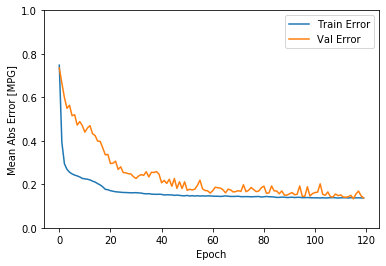

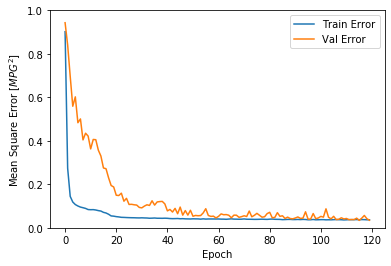

In [68]:
plot_history(history)

In [69]:
loss, mae, mse,mape,rmse_ann = model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann))

447/447 [==============================] - 1s 2ms/step - loss: -0.6042 - mse: 0.0358 - mae: 0.1387 - mape: 2819310.5000 - rmse_ann2: 0.1387
Testing set Mean Abs Error:  0.04 


Testing set Root Mean Abs Error:  0.14 


Text(0, 0.5, 'Frequency')

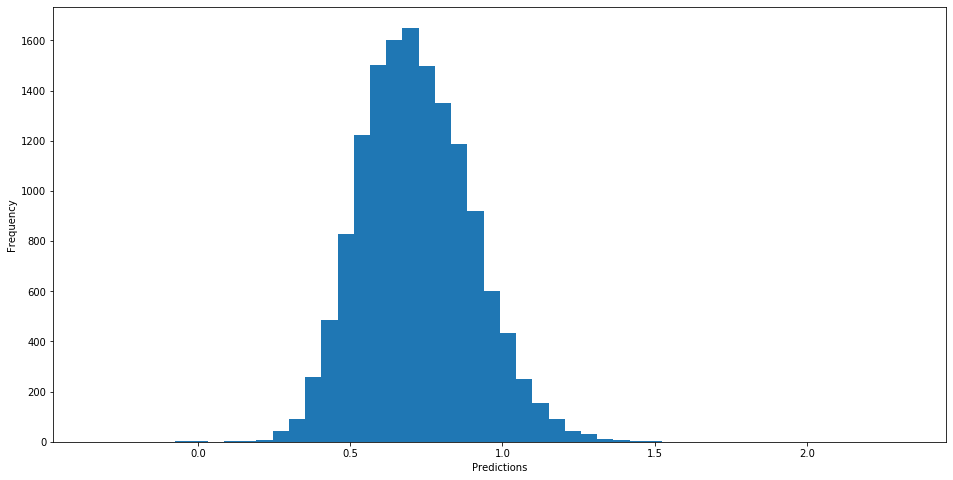

In [70]:
test_predictions = model.predict(X_test)
plt.figure(figsize=(16,8))
plt.hist(test_predictions,bins = 50)
plt.xlabel('Predictions')
plt.ylabel('Frequency')

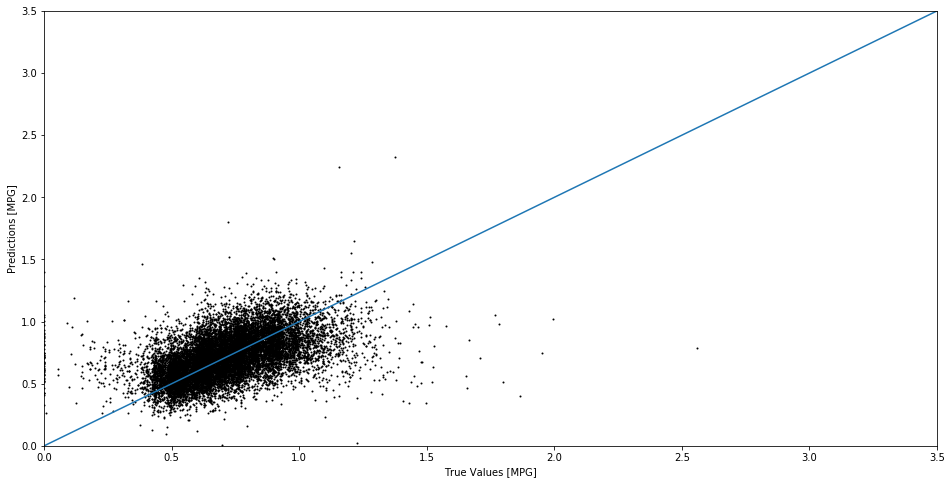

In [71]:
plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=1,c = "k")
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.xlim(0,3.5)
plt.ylim((0,3.5))
_ = plt.plot([-100, 100], [-100, 100])

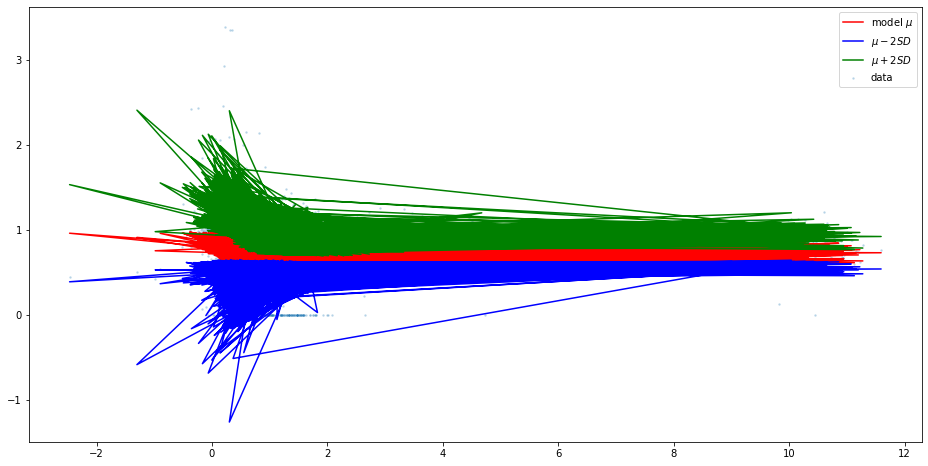

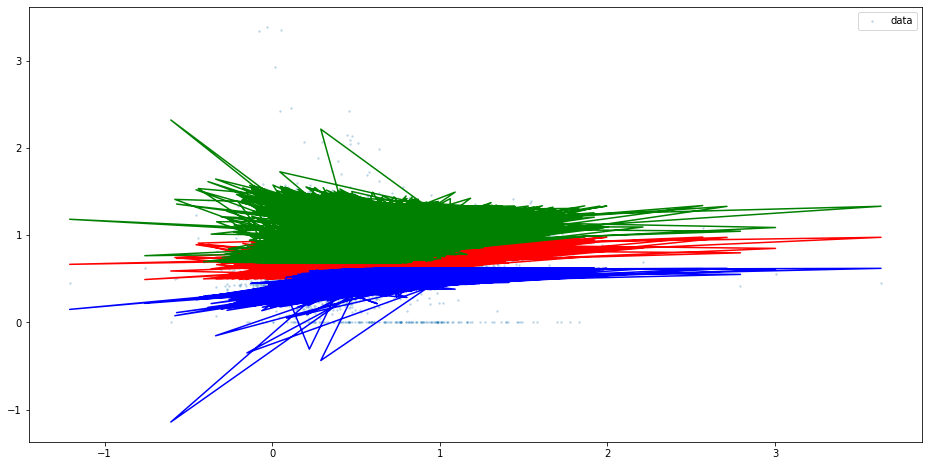

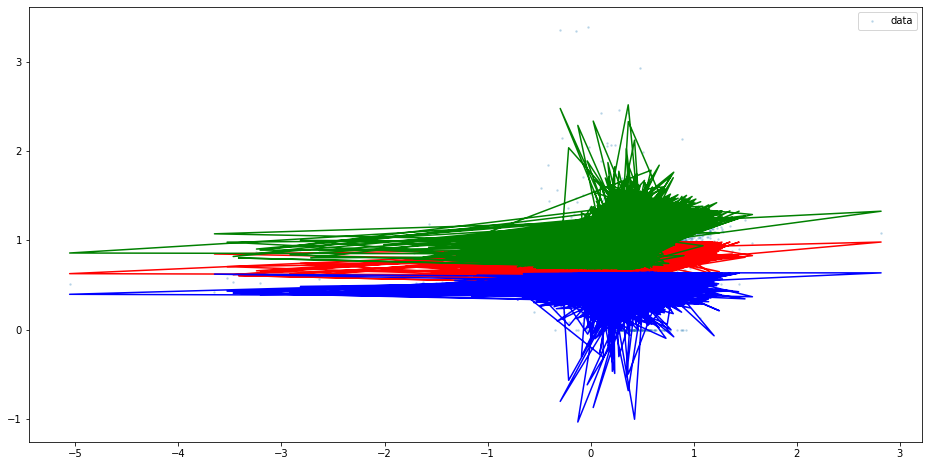

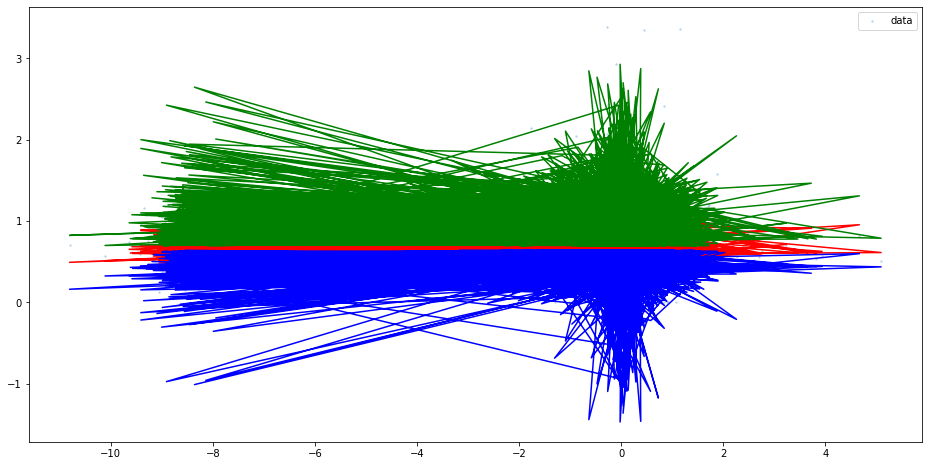

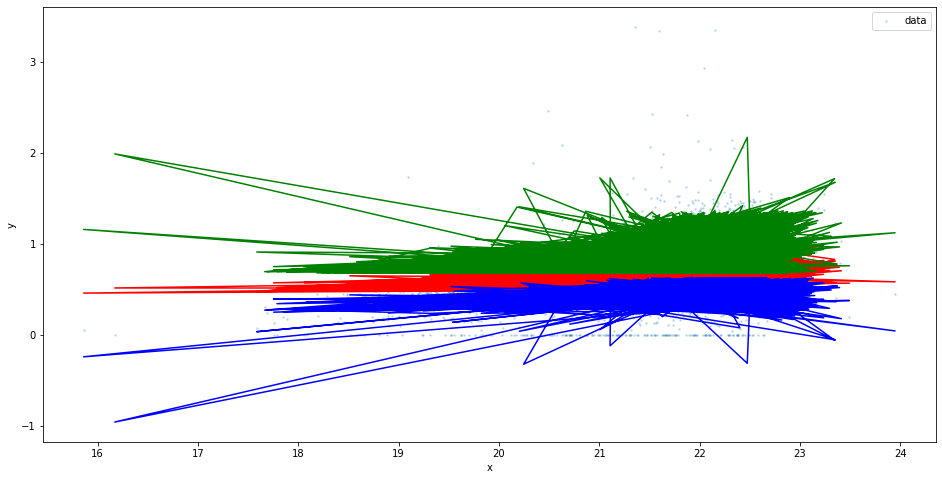

In [72]:
for i in range(5):
    plt.figure(figsize = (16,8))
    plt.scatter(X_train[:,i], y_train, marker='.', alpha=0.2, s = 10 ,label='data')
    y_model = model(X_train)
    y_hat = y_model.mean()
    y_hat_minus_2sd = y_hat - 2 * y_model.stddev()
    y_hat_plus_2sd = y_hat + 2 * y_model.stddev()
    plt.plot(X_train[:,i], y_hat, color='red', label='model $\mu$' if i == 0 else '')
    plt.plot(X_train[:,i], y_hat_minus_2sd, color='blue', label='$\mu - 2SD$' if i == 0 else '')
    plt.plot(X_train[:,i],y_hat_plus_2sd, color='green', label='$\mu + 2SD$' if i == 0 else '')
    plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.show()

### Stacked Methods

In [73]:
def nll2(y_true,y_pred):
    return -y_pred.log_prob(y_true)

def prior2(kernel_size,bias_size,dtype = None):
    n = kernel_size+bias_size #number of weigths
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n),scale_diag = tf.ones(n))
        )
    ])
    return prior_model

def posterior2(kernel_size,bias_size,dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
            
    ])
    return posterior_model


In [74]:
from ml_functions import AveragingModels
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def build_nn():

    ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dense(10, kernel_initializer='normal',  kernel_constraint=max_norm(2.5) ,activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       BatchNormalization(),
                       Dense(10,kernel_initializer='normal', kernel_constraint=max_norm(2.5) ,activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])
    opt = ks.optimizers.RMSprop(lr_schedule)
    #opt = tf.keras.optimizers.RMSprop(0.001)
    ann_model.compile(optimizer=opt, loss=rmse_ann3, metrics=['mse', 'mae', 'mape',rmse_ann3])
    
    return ann_model

def build_pnn():
    pnn_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                    BatchNormalization(),
                     tfpl.DenseVariational(units=10,
                          make_prior_fn=prior2,
                          make_posterior_fn=posterior2,
                          kl_weight=1/X_train.shape[0],activation =  "tanh"),
                    tfpl.DenseVariational(units=10,
                          make_prior_fn=prior2,
                          make_posterior_fn=posterior2,
                          kl_weight=1/X_train.shape[0],activation =  "tanh"),
                    
                    tfpl.DenseReparameterization( units = tfpl.IndependentNormal.params_size(1), activation=None,                                                
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
        kernel_divergence_fn = divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular = False),
        bias_divergence_fn = divergence_fn ),
                                                
                    tfpl.IndependentNormal(1)
                    
                      ])
    opt = ks.optimizers.RMSprop(lr_schedule)
    pnn_model.compile(optimizer=opt, loss=nll2, metrics=['mse', 'mae', 'mape',rmse_ann4])
    return pnn_model
    
    


pnn1_clf = tf.keras.wrappers.scikit_learn.KerasRegressor(
                            build_pnn,
                            epochs=20,batch_size=64,validation_split=0.2,
                            verbose=False)

ann1_clf = tf.keras.wrappers.scikit_learn.KerasRegressor(
                            build_nn,
                            epochs=10,batch_size=64,validation_split=0.2,
                            verbose=False)
ann1_clf._estimator_type = 'regressor'

pnn1_clf._estimator_type = 'regressor'



In [75]:
new_models.append(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=14,
                                                        min_samples_split=32,
                                                        splitter='random'),
                   learning_rate=1e-05, n_estimators=200))
                  
new_models.append(BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                       max_depth=14,
                                                       min_samples_split=32,
                                                       splitter='random'),
                  n_estimators=300))

In [76]:
new_models

[KNeighborsRegressor(n_neighbors=10),
 SGDRegressor(alpha=0.01),
 RandomForestRegressor(max_depth=18, min_samples_split=28),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                       min_samples_split=32, splitter='random'),
 Lasso(max_iter=200),
 KernelRidge(alpha=1e-08, degree=1),
 GradientBoostingRegressor(criterion='mae', loss='lad', max_features='sqrt',
                           n_estimators=200),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=14,
                                                        min_samples_split=32,
                                                        splitter='random'),
                   learning_rate=1e-05, n_estimators=200),
 BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                       max_depth=14,
                                                  

[0.019848382,
 0.025534383419871177,
 0.34338735133875137,
 0.018625713886721195,
 0.023267696557329517,
 0.038482860867853644,
 0.02822061973596205,
 0.018731674192475244]

In [77]:
new_models[2]

RandomForestRegressor(max_depth=18, min_samples_split=28)

In [101]:
stacked = StackingRegressor(estimators=[('Gbost', new_models[6]),
                         ('dtrbag',new_models[0]),
                         ('dtrboost',new_models[7]),
                         ('rfr', new_models[2]),
                        ("ann",ann1_clf)
                                        
                         ] ,final_estimator=new_models[0],cv = 5 ,passthrough = True)

In [102]:
stacked.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('Gbost',
                               GradientBoostingRegressor(criterion='mae',
                                                         loss='lad',
                                                         max_features='sqrt',
                                                         n_estimators=200)),
                              ('dtrbag', KNeighborsRegressor(n_neighbors=10)),
                              ('dtrboost',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                                                      max_depth=14,
                                                                                      min_samples_split=32,
                                                                                      splitter='random'),
                                                 learning_rate=1e-05,
                    

In [103]:
pred = stacked.predict(X_test)

In [110]:
print(" Stacked averaged base models score: ROOT MAE {:5.2f} MAE ({:5.2f})\n".format(rmsle(pred,y_test), mean_squared_error(pred,y_test)))

 Stacked averaged base models score: ROOT MAE  0.13 MAE ( 0.02)



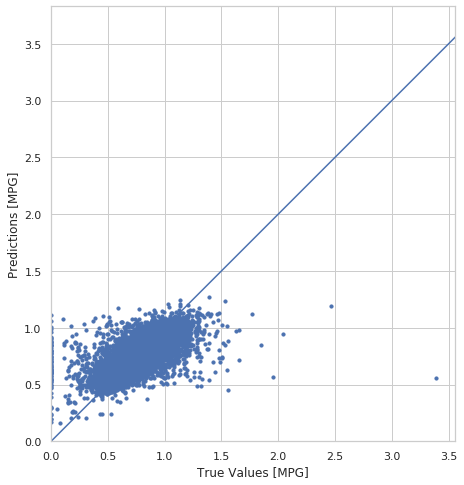

In [105]:
test_predictions = pred

plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=10)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Text(0, 0.5, 'Frequency')

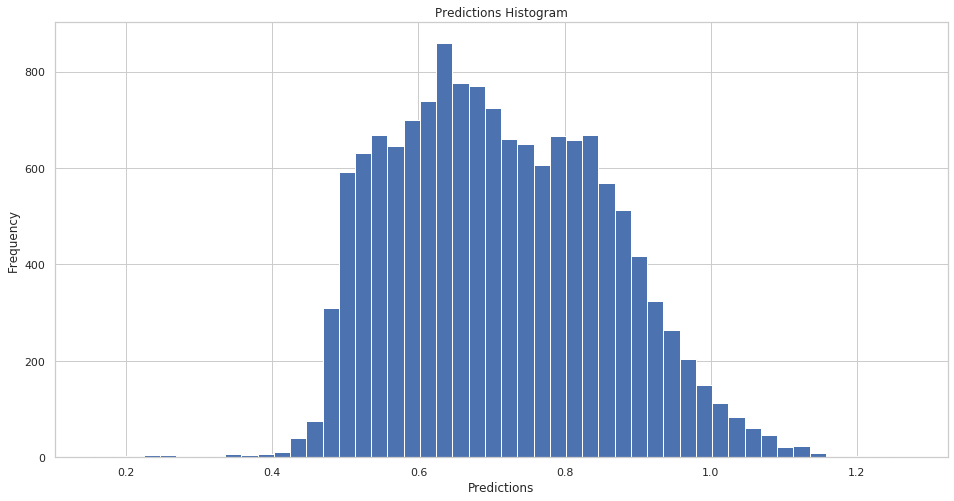

In [106]:
plt.figure(figsize=(16,8))
plt.hist(test_predictions,bins = 50)
plt.title("Predictions Histogram")
plt.xlabel('Predictions')
plt.ylabel('Frequency')

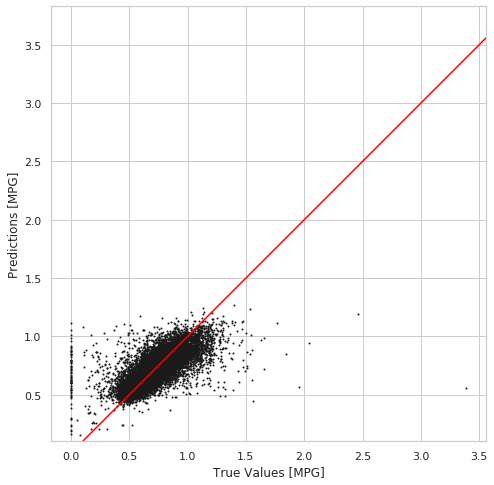

In [111]:
plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=1,c = "k")
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100],c = "red")
plt.savefig("scatter_stacked_vipers.png")

### mlxtend library

In [81]:
from mlxtend.regressor import StackingCVRegressor


In [82]:
stack = StackingCVRegressor(regressors=(new_models[0],new_models[6],new_models[7], ann1_clf,new_models[2]),
                            meta_regressor=new_models[0],
                            use_features_in_secondary=True,cv = 5,n_jobs = -1)


In [83]:
stack.fit(X_train,y_train)

StackingCVRegressor(meta_regressor=KNeighborsRegressor(n_neighbors=10),
                    n_jobs=-1,
                    regressors=(KNeighborsRegressor(n_neighbors=10),
                                GradientBoostingRegressor(criterion='mae',
                                                          loss='lad',
                                                          max_features='sqrt',
                                                          n_estimators=200),
                                AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                                                       max_depth=14,
                                                                                       min_samples_split=32,
                                                                                       splitter='random'),
                                                  learning_rate=1e-05,
                          

In [85]:
pred_1 = stack.predict(X_test)
print(" Stacked averaged base models score: ROOT MAE {:5.2f} MAE ({:5.2f})\n".format(rmsle(pred_1,y_test), mean_squared_error(pred_1,y_test)))

 Stacked averaged base models score: ROOT MAE  0.13 MAE ( 0.02)



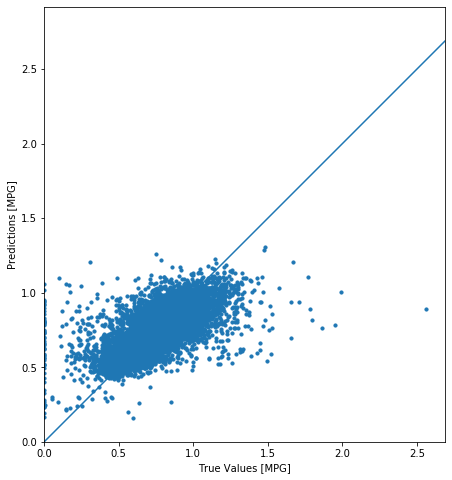

In [86]:
test_predictions = pred_1

plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=10)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Text(0, 0.5, 'Frequency')

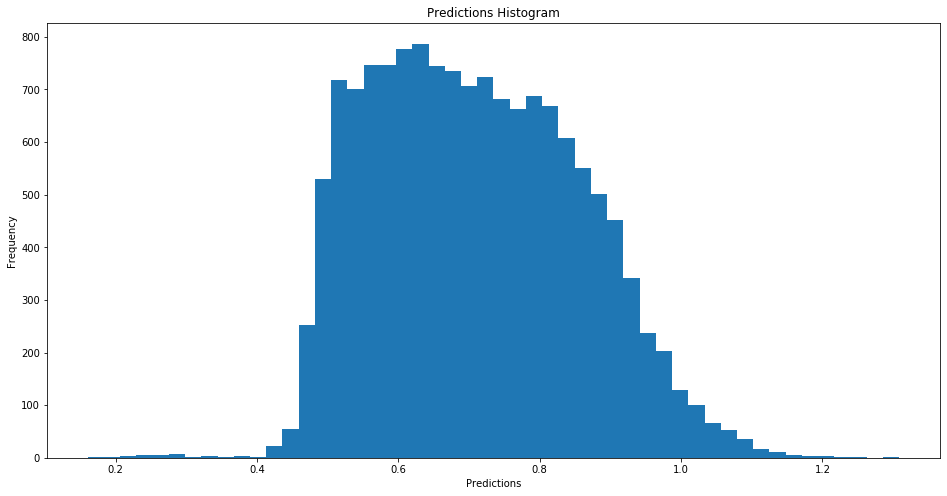

In [87]:
plt.figure(figsize=(16,8))
plt.hist(test_predictions,bins = 50)
plt.title("Predictions Histogram")
plt.xlabel('Predictions')
plt.ylabel('Frequency')

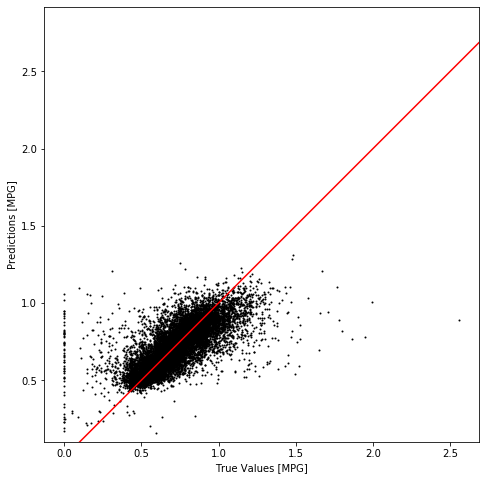

In [88]:
plt.figure(figsize=(16,8))
plt.scatter(y_test, test_predictions,s=1,c = "k")
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100],c = "red")